In [1]:
# ============================
# Block 1: Imports & settings
# ============================
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

# Reproducibility
RANDOM_STATE = 42

# Column name constants
ID_COL      = "PTID"
RMT_TP_COL  = "RMT_Timepoint"
DATE_COL    = "EXAMDATE"
SCORE_COL   = "SCREENER_SCORE"   # RMT screener score

# Minimum requirements
MIN_VISITS_FOR_SLOPE_RMT = 2    # at least 2 RMT visits per subject for a slope
MIN_N_REG                = 20   # heuristic minimum N for regression to be "meaningful"

# Fast-decline definition
FAST_DECLINE_QUANTILE = 0.30    # bottom 30% of slopes


In [2]:
# =========================================
# Block 2: Read RMT storyteller + sanity
# =========================================

# 2.1 Decide which columns to read
# (You can extend this list if you later want more acoustic detail.)
rmt_usecols = [
    # IDs / timing
    "RMT_PHASE", "ADNIOnlineID", "PTID", "RMT_Timepoint", "EXAMDATE",
    "SCREENER_SCORE",

    # STORY 1 – Immediate recall (content, fluency, timing)
    "STORY1IMM_NUM_WORDS",
    "STORY1IMM_IDEA_DENSITY",
    "STORY1IMM_UNIQUE_WORDS_RATIO",
    "STORY1IMM_MEAN_LETTER_PER_WORD",
    "STORY1IMM_GMATCH",
    "STORY1IMM_SPEECH_DURATION",
    "STORY1IMM_NONSPEECH_PROPORTION",
    "STORY1IMM_SPEECH_RATE",
    "STORY1IMM_ARTICULATION_RATE",
    "STORY1IMM_NUM_PAUSES",
    "STORY1IMM_MEAN_PAUSE_LENGTH",
    "STORY1IMM_F0_MEAN",
    "STORY1IMM_F0_SD",
    "STORY1IMM_INTENSITY_MEAN",
    "STORY1IMM_INTENSITY_SD",

    # STORY 2 – Immediate recall
    "STORY2IMM_NUM_WORDS",
    "STORY2IMM_IDEA_DENSITY",
    "STORY2IMM_UNIQUE_WORDS_RATIO",
    "STORY2IMM_MEAN_LETTER_PER_WORD",
    "STORY2IMM_GMATCH",
    "STORY2IMM_SPEECH_DURATION",
    "STORY2IMM_NONSPEECH_PROPORTION",
    "STORY2IMM_SPEECH_RATE",
    "STORY2IMM_ARTICULATION_RATE",
    "STORY2IMM_NUM_PAUSES",
    "STORY2IMM_MEAN_PAUSE_LENGTH",
    "STORY2IMM_F0_MEAN",
    "STORY2IMM_F0_SD",
    "STORY2IMM_INTENSITY_MEAN",
    "STORY2IMM_INTENSITY_SD",

    # STORY 1 – Delayed recall
    "STORY1DEL_NUM_WORDS",
    "STORY1DEL_IDEA_DENSITY",
    "STORY1DEL_UNIQUE_WORDS_RATIO",
    "STORY1DEL_MEAN_LETTER_PER_WORD",
    "STORY1DEL_GMATCH",
    "STORY1DEL_GMATCH_IMM_DEL",
    "STORY1DEL_SPEECH_DURATION",
    "STORY1DEL_NONSPEECH_PROPORTION",
    "STORY1DEL_SPEECH_RATE",
    "STORY1DEL_ARTICULATION_RATE",
    "STORY1DEL_NUM_PAUSES",
    "STORY1DEL_MEAN_PAUSE_LENGTH",
    "STORY1DEL_F0_MEAN",
    "STORY1DEL_F0_SD",
    "STORY1DEL_INTENSITY_MEAN",
    "STORY1DEL_INTENSITY_SD",
]

# Read header once to guard against missing columns
rmt_header = pd.read_csv("adnidata/RMT_STORYTELLER_17Jan2026.csv", nrows=0)
available_cols = rmt_header.columns.tolist()

rmt_usecols_present = [c for c in rmt_usecols if c in available_cols]

print("Total columns available in RMT file:", len(available_cols))
print("Columns we will use:", len(rmt_usecols_present))

# 2.2 Load RMT storyteller
rmt = pd.read_csv(
    "adnidata/RMT_STORYTELLER_17Jan2026.csv",
    usecols=rmt_usecols_present,
    parse_dates=["EXAMDATE"],
    dtype={
        "PTID": "string",
        "ADNIOnlineID": "string",
        "RMT_PHASE": "string",
        "RMT_Timepoint": "string",
    },
)

print("RMT shape:", rmt.shape)
print("\nRMT head:")
print(rmt.head(5))

# 2.3 Basic screener sanity check
print("\nSCREENER_SCORE missingness:")
print(rmt[SCORE_COL].isna().value_counts())
print("\nRMT_Timepoint value counts:")
print(rmt[RMT_TP_COL].value_counts().head(10))


Total columns available in RMT file: 219
Columns we will use: 52
RMT shape: (14823, 52)

RMT head:
  RMT_PHASE   ADNIOnlineID  PTID RMT_Timepoint   EXAMDATE  SCREENER_SCORE  \
0     ADNI4  ADNI4-PYP-9P9  <NA>           m00 2023-06-21              57   
1     ADNI4  ADNI4-PYP-9P9  <NA>           m06 2024-01-12              57   
2     ADNI4  ADNI4-PGP-PNH  <NA>           m00 2023-06-28              72   
3     ADNI4  ADNI4-PGP-PNH  <NA>           m06 2024-01-02              64   
4     ADNI4  ADNI4-PGP-PNH  <NA>           m12 2024-07-03              71   

   STORY1IMM_NUM_WORDS  STORY1IMM_IDEA_DENSITY  STORY1IMM_UNIQUE_WORDS_RATIO  \
0                 37.0                0.405405                      0.783784   
1                 61.0                0.360656                      0.754098   
2                 79.0                0.455696                      0.632911   
3                 92.0                0.467391                      0.597826   
4                131.0                

In [5]:
# ============================
# BLOCK 3 – RMT-only panel
# ============================
import numpy as np
import pandas as pd

# ---- 3.0 Key column names and settings ----
ID_COL            = "ADNIOnlineID"    # subject ID for RMT-only analysis
RMT_DATE_COL      = "EXAMDATE"
RMT_TP_COL        = "RMT_Timepoint"
SCORE_COL         = "SCREENER_SCORE"
MAX_MONTHS_FOLLOWUP_RMT = 18.0        # stop at m18

# 3.1 Ensure EXAMDATE is datetime (even if we don't rely on it for time encoding)
rmt[RMT_DATE_COL] = pd.to_datetime(rmt[RMT_DATE_COL], errors="coerce")

# 3.2 Basic sanity checks
print("SCREENER_SCORE missingness:")
print(rmt[SCORE_COL].isna().value_counts())

print("\nRMT_Timepoint value counts:")
print(rmt[RMT_TP_COL].value_counts(dropna=False))

# 3.3 Map RMT_Timepoint to months from baseline
tp_to_months = {
    "m00": 0.0,
    "m06": 6.0,
    "m12": 12.0,
    "m18": 18.0,
    "m24": 24.0,   # we will later trim to <= 18
}

rmt["tp_months"] = rmt[RMT_TP_COL].map(tp_to_months)
rmt["tp_years"]  = rmt["tp_months"] / 12.0

print("\nTimepoint → months mapping (first few rows):")
print(rmt[[ID_COL, RMT_TP_COL, "tp_months", "tp_years"]].head())

# 3.4 Identify narrative feature columns (everything except ID/timing/screener)
non_feature_cols = {
    "RMT_PHASE",
    "ADNIOnlineID",
    "PTID",
    "RMT_Timepoint",
    "EXAMDATE",
    "SCREENER_SCORE",
    "tp_months",
    "tp_years",
}
narrative_cols = [c for c in rmt.columns if c not in non_feature_cols]

print(f"\nNumber of narrative feature columns: {len(narrative_cols)}")

# 3.5 Assemble the working panel (RMT-only, with time variables)
panel = rmt[[ID_COL, RMT_TP_COL, RMT_DATE_COL, SCORE_COL, "tp_months", "tp_years"] + narrative_cols].copy()

print("\nRaw panel shape (all timepoints):", panel.shape)
print("Unique subjects in raw panel:", panel[ID_COL].nunique())

# 3.6 Trim to 0–18 months (m00–m18) for the RMT-only longitudinal window
panel = panel[
    panel["tp_months"].notna()
    & panel["tp_months"].between(0, MAX_MONTHS_FOLLOWUP_RMT)
].copy()

panel["months_from_baseline"] = panel["tp_months"]
panel["years_from_baseline"]  = panel["tp_years"]

print("Trimmed panel shape (0–18 months only):", panel.shape)
print("Unique subjects in trimmed panel:", panel[ID_COL].nunique())
print("RMT_Timepoint distribution in trimmed panel:")
print(panel[RMT_TP_COL].value_counts(dropna=False))


SCREENER_SCORE missingness:
SCREENER_SCORE
False    14823
Name: count, dtype: int64

RMT_Timepoint value counts:
RMT_Timepoint
m00    8179
m06    4374
m12    1968
m18     287
m24      15
Name: count, dtype: Int64

Timepoint → months mapping (first few rows):
    ADNIOnlineID RMT_Timepoint  tp_months  tp_years
0  ADNI4-PYP-9P9           m00        0.0       0.0
1  ADNI4-PYP-9P9           m06        6.0       0.5
2  ADNI4-PGP-PNH           m00        0.0       0.0
3  ADNI4-PGP-PNH           m06        6.0       0.5
4  ADNI4-PGP-PNH           m12       12.0       1.0

Number of narrative feature columns: 46

Raw panel shape (all timepoints): (14823, 52)
Unique subjects in raw panel: 8761
Trimmed panel shape (0–18 months only): (14808, 54)
Unique subjects in trimmed panel: 8761
RMT_Timepoint distribution in trimmed panel:
RMT_Timepoint
m00    8179
m06    4374
m12    1968
m18     287
Name: count, dtype: Int64


In [6]:
# ============================
# BLOCK 4 – Screener slopes
# ============================
from sklearn.linear_model import LinearRegression

print("\nSTEP 4 – RMT-internal screener slopes...")

MIN_VISITS_FOR_SLOPE = 2   # with RMT timepoints, 2+ visits should be common

def compute_screener_slope(df_sub, time_col="tp_years", score_col=SCORE_COL):
    """
    Compute screener slope (points per year) for a single subject.
    Requires at least MIN_VISITS_FOR_SLOPE non-missing scores.
    """
    df_sub = df_sub.dropna(subset=[time_col, score_col]).copy()
    if df_sub.shape[0] < MIN_VISITS_FOR_SLOPE:
        return np.nan

    X = df_sub[[time_col]].values
    y = df_sub[score_col].values

    model = LinearRegression()
    model.fit(X, y)
    return model.coef_[0]   # slope in points per year

# 4.1 Compute slopes for each subject in the trimmed RMT panel
slopes = []
for sid, sub in panel.groupby(ID_COL):
    slope = compute_screener_slope(sub, time_col="tp_years", score_col=SCORE_COL)
    slopes.append((sid, slope))

slopes_df = pd.DataFrame(slopes, columns=[ID_COL, "ScreenerSlope_perYear"])

print("\nNon-missing screener slopes available:")
print(slopes_df["ScreenerSlope_perYear"].dropna().describe())

print("Screener slopes estimated for N subjects:",
      slopes_df["ScreenerSlope_perYear"].notna().sum())

# 4.2 Define “fast RMT decliners” as those in the bottom 30% of slopes
valid_slopes = slopes_df["ScreenerSlope_perYear"].dropna()
if len(valid_slopes) > 0:
    q30 = valid_slopes.quantile(0.30)
    slopes_df["FastRMTDecliner"] = np.where(
        (slopes_df["ScreenerSlope_perYear"].notna()) &
        (slopes_df["ScreenerSlope_perYear"] <= q30),
        1,
        0
    )

    print("\nFast RMT decliner threshold (30th percentile of slope):", q30)
    print("FastRMTDecliner counts:")
    print(slopes_df["FastRMTDecliner"].value_counts(dropna=False))
else:
    print("\nNo valid slopes to define FastRMTDecliner; all slopes are NaN.")
    slopes_df["FastRMTDecliner"] = np.nan



STEP 4 – RMT-internal screener slopes...

Non-missing screener slopes available:
count    4435.000000
mean        3.925448
std        23.095182
min      -182.000000
25%        -3.000000
50%         4.000000
75%        12.000000
max       170.000000
Name: ScreenerSlope_perYear, dtype: float64
Screener slopes estimated for N subjects: 4435

Fast RMT decliner threshold (30th percentile of slope): -0.9999999999999998
FastRMTDecliner counts:
FastRMTDecliner
0    7412
1    1349
Name: count, dtype: int64


In [7]:
# ============================
# BLOCK 5 – Baseline composites & analytic table
# ============================
print("\nSTEP 5 – Baseline narrative composites and analytic RMT dataset...")

# 5.1 Baseline rows = m00 timepoint
baseline_rows = panel[panel[RMT_TP_COL] == "m00"].copy()
print("Baseline rows (m00):", baseline_rows.shape[0])

# 5.2 Define narrative families by column name patterns
content_cols = [
    c for c in narrative_cols
    if any([
        c.endswith("IDEA_DENSITY"),
        c.endswith("UNIQUE_WORDS_RATIO"),
        c.endswith("MEAN_LETTER_PER_WORD"),
        c.endswith("GMATCH"),
        c.endswith("NUM_WORDS"),
    ])
]

fluency_cols = [
    c for c in narrative_cols
    if any([
        c.endswith("SPEECH_DURATION"),
        c.endswith("NONSPEECH_PROPORTION"),
        c.endswith("SPEECH_RATE"),
        c.endswith("ARTICULATION_RATE"),
        c.endswith("NUM_PAUSES"),
        c.endswith("MEAN_PAUSE_LENGTH"),
    ])
]

voice_cols = [
    c for c in narrative_cols
    if any([
        c.endswith("F0_MEAN"),
        c.endswith("F0_SD"),
        c.endswith("INTENSITY_MEAN"),
        c.endswith("INTENSITY_SD"),
        "MFCC_" in c,
        "JITTER" in c.upper(),
        "SHIMMER" in c.upper(),
        "FORMANTS_" in c,
    ])
]

print(f"# content_cols: {len(content_cols)}")
print(f"# fluency_cols: {len(fluency_cols)}")
print(f"# voice_cols:   {len(voice_cols)}")

# 5.3 Extract baseline narrative features
baseline_features = baseline_rows[[ID_COL] + content_cols + fluency_cols + voice_cols].copy()

# 5.4 Helper: z-score within baseline for each family
def zscore_block(df, cols):
    z = df[cols].copy()
    for col in cols:
        mu = z[col].mean(skipna=True)
        sd = z[col].std(skipna=True)
        if sd == 0 or np.isnan(sd):
            z[col] = np.nan
        else:
            z[col] = (z[col] - mu) / sd
    return z

baseline_z = baseline_features.copy()
baseline_z[content_cols] = zscore_block(baseline_features, content_cols)
baseline_z[fluency_cols] = zscore_block(baseline_features, fluency_cols)
baseline_z[voice_cols]   = zscore_block(baseline_features, voice_cols)

# 5.5 Composite scores: mean of z-scored features in each family
baseline_z["ContentComposite"] = baseline_z[content_cols].mean(axis=1, skipna=True)
baseline_z["FluencyComposite"] = baseline_z[fluency_cols].mean(axis=1, skipna=True)
baseline_z["VoiceComposite"]   = baseline_z[voice_cols].mean(axis=1, skipna=True)

baseline_composites = baseline_z[[ID_COL, "ContentComposite", "FluencyComposite", "VoiceComposite"]].copy()

print("\nBaseline composites head:")
print(baseline_composites.head())

# 5.6 Baseline screener score at m00
baseline_screener = baseline_rows[[ID_COL, SCORE_COL]].copy()
baseline_screener = baseline_screener.rename(columns={SCORE_COL: "BaselineScreener"})

# 5.7 Assemble analytic RMT dataset (baseline predictors + longitudinal outcomes)
analytic_rmt = (
    baseline_composites
    .merge(baseline_screener, on=ID_COL, how="left")
    .merge(slopes_df[[ID_COL, "ScreenerSlope_perYear", "FastRMTDecliner"]],
           on=ID_COL,
           how="left")
)

print("\nAnalytic RMT dataset shape (before dropping NAs):", analytic_rmt.shape)
print(analytic_rmt.head())



STEP 5 – Baseline narrative composites and analytic RMT dataset...
Baseline rows (m00): 8179
# content_cols: 15
# fluency_cols: 18
# voice_cols:   12

Baseline composites head:
     ADNIOnlineID  ContentComposite  FluencyComposite  VoiceComposite
0   ADNI4-PYP-9P9         -0.338957         -0.050561        1.765791
2   ADNI4-PGP-PNH          0.368843          0.249366        0.524741
6   ADNI4-KQ6-64P          0.193947         -0.172423        0.067106
10  ADNI4-NKQ-GLR          0.145482          0.096685       -0.077183
13  ADNI4-NX3-K33         -0.202198          0.387615        0.656294

Analytic RMT dataset shape (before dropping NAs): (8179, 7)
    ADNIOnlineID  ContentComposite  FluencyComposite  VoiceComposite  \
0  ADNI4-PYP-9P9         -0.338957         -0.050561        1.765791   
1  ADNI4-PGP-PNH          0.368843          0.249366        0.524741   
2  ADNI4-KQ6-64P          0.193947         -0.172423        0.067106   
3  ADNI4-NKQ-GLR          0.145482          0.096685 

In [8]:
# ============================
# BLOCK 6 – Regression & logistic models (RMT-only)
# ============================
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, LogisticRegression

print("\nSTEP 6 – Models: baseline narrative composites predicting RMT screener decline...")

# 6.1 Regression: baseline composites → ScreenerSlope_perYear
predictor_cols = ["ContentComposite", "FluencyComposite", "VoiceComposite", "BaselineScreener"]

analytic_reg = analytic_rmt.dropna(subset=predictor_cols + ["ScreenerSlope_perYear"]).copy()
print("Regression sample size (RMT slope) after dropping missing:", analytic_reg.shape[0])

if analytic_reg.shape[0] >= 10:
    X = analytic_reg[predictor_cols].copy()
    y = analytic_reg["ScreenerSlope_perYear"].values

    # Standardise predictors for comparable coefficients
    X_mean = X.mean()
    X_std  = X.std(ddof=0).replace(0, 1.0)
    X_stdzd = (X - X_mean) / X_std

    ols_model = LinearRegression()
    ols_model.fit(X_stdzd, y)

    coef_df = pd.DataFrame({
        "Predictor": predictor_cols,
        "StdCoef":  ols_model.coef_
    }).sort_values("StdCoef", key=lambda s: s.abs(), ascending=False)

    print("\n[6A] Linear regression: baseline composites → RMT ScreenerSlope_perYear")
    print("Standardised coefficients (larger |StdCoef| = stronger association):")
    print(coef_df)

    y_pred = ols_model.predict(X_stdzd)
    print("\nModel fit (RMT screener slope):")
    print("R^2 :", r2_score(y, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))
else:
    print("Too few complete cases for a meaningful regression model; skipping regression.")

# 6.2 Logistic: predicting FastRMTDecliner from baseline composites
analytic_log = analytic_rmt.dropna(subset=predictor_cols + ["FastRMTDecliner"]).copy()

if analytic_log.shape[0] >= 20 and analytic_log["FastRMTDecliner"].nunique() == 2:
    X_fast = analytic_log[predictor_cols].copy()
    y_fast = analytic_log["FastRMTDecliner"].astype(int).values

    fast_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(max_iter=1000))
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fast_auc = cross_val_score(fast_pipeline, X_fast, y_fast, cv=cv, scoring="roc_auc")

    print(f"\n[6B] Logistic regression: FastRMTDecliner")
    print(f"Fast-decline sample size: {analytic_log.shape[0]}")
    print(f"CV AUC (mean ± SD): {fast_auc.mean():.3f} ± {fast_auc.std():.3f}")

    fast_pipeline.fit(X_fast, y_fast)
    logreg_fast = fast_pipeline.named_steps["logreg"]
    coef_fast = pd.DataFrame({
        "Predictor": predictor_cols,
        "Coef":      logreg_fast.coef_.flatten()
    }).sort_values("Coef", key=lambda s: s.abs(), ascending=False)

    print("\nLogistic regression coefficients for FastRMTDecliner (scaled predictors):")
    print(coef_fast)
else:
    print("\nNot enough data or only one class for FastRMTDecliner – skipping logistic model.")



STEP 6 – Models: baseline narrative composites predicting RMT screener decline...
Regression sample size (RMT slope) after dropping missing: 4311

[6A] Linear regression: baseline composites → RMT ScreenerSlope_perYear
Standardised coefficients (larger |StdCoef| = stronger association):
          Predictor   StdCoef
3  BaselineScreener -6.357753
1  FluencyComposite -1.664376
0  ContentComposite -0.413088
2    VoiceComposite -0.198453

Model fit (RMT screener slope):
R^2 : 0.1145711452782735
RMSE: 21.44361812891687

[6B] Logistic regression: FastRMTDecliner
Fast-decline sample size: 8174
CV AUC (mean ± SD): 0.656 ± 0.012

Logistic regression coefficients for FastRMTDecliner (scaled predictors):
          Predictor      Coef
3  BaselineScreener  0.760837
0  ContentComposite -0.149984
1  FluencyComposite  0.052428
2    VoiceComposite  0.021852


In [11]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LassoCV, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score

# -------------------------------------------------------------------
# Assumptions:
#   - analytic_rmt exists from previous steps
#   - analytic_rmt has columns:
#       * Subject ID column: usually "ADNIOnlineID" (or "PTID")
#       * "ContentComposite", "FluencyComposite", "VoiceComposite"
#       * "BaselineScreener", "ScreenerSlope_perYear", "FastRMTDecliner"
# -------------------------------------------------------------------

print("Analytic RMT dataset (row-level) shape:", analytic_rmt.shape)
print("Analytic RMT columns:", list(analytic_rmt.columns))

# --- 7A.0 Pick the subject ID column automatically ---
id_candidates = ["ADNIOnlineID", "PTID", "SUBJECT_ID"]
id_available = [c for c in id_candidates if c in analytic_rmt.columns]

if not id_available:
    raise KeyError(
        "Could not find a subject ID column in analytic_rmt. "
        "Looked for any of: 'ADNIOnlineID', 'PTID', 'SUBJECT_ID'. "
        f"Found columns: {list(analytic_rmt.columns)}"
    )

ID_COL = id_available[0]
print(f"Using '{ID_COL}' as subject ID column.")

# --- 7A.1 Collapse to one row per subject ---
agg_dict = {
    "ContentComposite": "mean",
    "FluencyComposite": "mean",
    "VoiceComposite": "mean",
    "BaselineScreener": "mean",
    "ScreenerSlope_perYear": "first",
    "FastRMTDecliner": "first",
}

analytic_rmt_subj = (
    analytic_rmt
    .groupby(ID_COL, as_index=False)
    .agg(agg_dict)
)

print("Subject-level analytic RMT dataset shape:", analytic_rmt_subj.shape)
print(analytic_rmt_subj.head())

# --- 7A.2 Narrative-only predictors ---
narr_feature_cols = ["ContentComposite", "FluencyComposite", "VoiceComposite"]

# For slope analysis: need non-missing slope + composites
analytic_rmt_slope = analytic_rmt_subj.dropna(
    subset=["ScreenerSlope_perYear"] + narr_feature_cols
).copy()

print(
    "\nSlope dataset (narrative-only) – N subjects:",
    analytic_rmt_slope.shape[0]
)

X_slope_narr = analytic_rmt_slope[narr_feature_cols].values
y_slope = analytic_rmt_slope["ScreenerSlope_perYear"].values

# For fast-decline analysis: need FastRMTDecliner label + composites
analytic_rmt_fast = analytic_rmt_subj.dropna(
    subset=["FastRMTDecliner"] + narr_feature_cols
).copy()

analytic_rmt_fast["FastRMTDecliner"] = analytic_rmt_fast["FastRMTDecliner"].astype(int)

X_fast_narr = analytic_rmt_fast[narr_feature_cols].values
y_fast = analytic_rmt_fast["FastRMTDecliner"].values

print(
    "Fast-decline dataset (narrative-only) – N subjects:",
    analytic_rmt_fast.shape[0],
    " | Class balance:",
    np.bincount(y_fast)
)


Analytic RMT dataset (row-level) shape: (8179, 7)
Analytic RMT columns: ['ADNIOnlineID', 'ContentComposite', 'FluencyComposite', 'VoiceComposite', 'BaselineScreener', 'ScreenerSlope_perYear', 'FastRMTDecliner']
Using 'ADNIOnlineID' as subject ID column.
Subject-level analytic RMT dataset shape: (8179, 7)
    ADNIOnlineID  ContentComposite  FluencyComposite  VoiceComposite  \
0  ADNI4-333-MDN          0.308284          0.231776        0.587796   
1  ADNI4-333-RJX         -0.147930         -0.287433       -0.518951   
2  ADNI4-333-XLR         -0.091111          0.330118        0.530012   
3  ADNI4-334-KXJ         -0.079107          0.102349        1.947817   
4  ADNI4-336-476          0.308977          0.292311       -0.062392   

   BaselineScreener  ScreenerSlope_perYear  FastRMTDecliner  
0              87.0                    0.0                0  
1              73.0                    NaN                0  
2              69.0                    NaN                0  
3            

In [12]:
# ============================================================
# 7B. Narrative-only models for ScreenerSlope_perYear
# ============================================================

print("\n[7B] Narrative-only models for ScreenerSlope_perYear")

# ---- 7B.1 Simple linear regression (baseline) ----
lin_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("linreg", LinearRegression())
])

kf = KFold(n_splits=5, shuffle=True, random_state=42)

lin_r2_cv = cross_val_score(
    lin_pipeline, X_slope_narr, y_slope,
    cv=kf, scoring="r2"
)
lin_rmse_cv = np.sqrt(-cross_val_score(
    lin_pipeline, X_slope_narr, y_slope,
    cv=kf, scoring="neg_mean_squared_error"
))

print(f"Linear regression (narrative-only) – CV R²: {lin_r2_cv.mean():.3f} ± {lin_r2_cv.std():.3f}")
print(f"Linear regression (narrative-only) – CV RMSE: {lin_rmse_cv.mean():.2f} ± {lin_rmse_cv.std():.2f}")

# Fit on full slope dataset for coefficients
lin_pipeline.fit(X_slope_narr, y_slope)
lin_coef = lin_pipeline.named_steps["linreg"].coef_
coef_df_narr_lin = pd.DataFrame({
    "Predictor": narr_feature_cols,
    "StdCoef": lin_coef  # because we scaled before
}).sort_values("StdCoef", key=lambda s: s.abs(), ascending=False)

print("\nLinear regression standardized coefficients (narrative-only):")
print(coef_df_narr_lin)

# ---- 7B.2 LassoCV (penalized linear model) ----
lasso_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("lasso", LassoCV(cv=5, random_state=42))
])

lasso_pipeline.fit(X_slope_narr, y_slope)
lasso = lasso_pipeline.named_steps["lasso"]

print(f"\nLassoCV (narrative-only) – chosen alpha: {lasso.alpha_:.4f}")
lasso_coef = lasso.coef_

coef_df_narr_lasso = pd.DataFrame({
    "Predictor": narr_feature_cols,
    "LassoCoef": lasso_coef
}).sort_values("LassoCoef", key=lambda s: s.abs(), ascending=False)

print("Lasso coefficients (some may shrink toward 0):")
print(coef_df_narr_lasso)

# Cross-validated performance for Lasso
lasso_r2_cv = cross_val_score(
    lasso_pipeline, X_slope_narr, y_slope,
    cv=kf, scoring="r2"
)
lasso_rmse_cv = np.sqrt(-cross_val_score(
    lasso_pipeline, X_slope_narr, y_slope,
    cv=kf, scoring="neg_mean_squared_error"
))

print(f"Lasso (narrative-only) – CV R²: {lasso_r2_cv.mean():.3f} ± {lasso_r2_cv.std():.3f}")
print(f"Lasso (narrative-only) – CV RMSE: {lasso_rmse_cv.mean():.2f} ± {lasso_rmse_cv.std():.2f}")

# ---- 7B.3 Random Forest regressor ----
rf_reg = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_r2_cv = cross_val_score(
    rf_reg, X_slope_narr, y_slope,
    cv=kf, scoring="r2"
)
rf_rmse_cv = np.sqrt(-cross_val_score(
    rf_reg, X_slope_narr, y_slope,
    cv=kf, scoring="neg_mean_squared_error"
))

print(f"\nRandomForestRegressor (narrative-only) – CV R²: {rf_r2_cv.mean():.3f} ± {rf_r2_cv.std():.3f}")
print(f"RandomForestRegressor (narrative-only) – CV RMSE: {rf_rmse_cv.mean():.2f} ± {rf_rmse_cv.std():.2f}")

# Fit RF on full data to inspect feature importances
rf_reg.fit(X_slope_narr, y_slope)
rf_importances = rf_reg.feature_importances_

rf_imp_df = pd.DataFrame({
    "Predictor": narr_feature_cols,
    "RF_importance": rf_importances
}).sort_values("RF_importance", ascending=False)

print("\nRandom Forest feature importances (narrative-only):")
print(rf_imp_df)



[7B] Narrative-only models for ScreenerSlope_perYear
Linear regression (narrative-only) – CV R²: 0.081 ± 0.010
Linear regression (narrative-only) – CV RMSE: 21.69 ± 2.37

Linear regression standardized coefficients (narrative-only):
          Predictor   StdCoef
0  ContentComposite -4.942201
1  FluencyComposite -2.602390
2    VoiceComposite -0.327544

LassoCV (narrative-only) – chosen alpha: 0.0063
Lasso coefficients (some may shrink toward 0):
          Predictor  LassoCoef
0  ContentComposite  -4.939027
1  FluencyComposite  -2.597672
2    VoiceComposite  -0.321531
Lasso (narrative-only) – CV R²: 0.081 ± 0.010
Lasso (narrative-only) – CV RMSE: 21.69 ± 2.37

RandomForestRegressor (narrative-only) – CV R²: -0.032 ± 0.053
RandomForestRegressor (narrative-only) – CV RMSE: 22.94 ± 2.08

Random Forest feature importances (narrative-only):
          Predictor  RF_importance
1  FluencyComposite       0.349630
0  ContentComposite       0.328508
2    VoiceComposite       0.321862


In [13]:
# ============================================================
# 7C. Narrative-only models for FastRMTDecliner
# ============================================================

print("\n[7C] Narrative-only models for FastRMTDecliner")

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ---- 7C.1 Logistic regression with scaling ----
logit_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=2000))
])

logit_auc_cv = cross_val_score(
    logit_pipeline, X_fast_narr, y_fast,
    cv=skf, scoring="roc_auc"
)

print(f"Logistic regression (narrative-only) – CV AUC: {logit_auc_cv.mean():.3f} ± {logit_auc_cv.std():.3f}")

logit_pipeline.fit(X_fast_narr, y_fast)
logit_coef = logit_pipeline.named_steps["logreg"].coef_.flatten()

coef_df_fast_logit = pd.DataFrame({
    "Predictor": narr_feature_cols,
    "Coef": logit_coef
}).sort_values("Coef", key=lambda s: s.abs(), ascending=False)

print("\nLogistic regression coefficients for FastRMTDecliner (scaled predictors, narrative-only):")
print(coef_df_fast_logit)

# ---- 7C.2 Random Forest classifier ----
rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_auc_cv = cross_val_score(
    rf_clf, X_fast_narr, y_fast,
    cv=skf, scoring="roc_auc"
)

print(f"\nRandomForestClassifier (narrative-only) – CV AUC: {rf_auc_cv.mean():.3f} ± {rf_auc_cv.std():.3f}")

rf_clf.fit(X_fast_narr, y_fast)
rf_clf_importances = rf_clf.feature_importances_

rf_clf_imp_df = pd.DataFrame({
    "Predictor": narr_feature_cols,
    "RF_importance": rf_clf_importances
}).sort_values("RF_importance", ascending=False)

print("\nRandom Forest feature importances for FastRMTDecliner (narrative-only):")
print(rf_clf_imp_df)



[7C] Narrative-only models for FastRMTDecliner
Logistic regression (narrative-only) – CV AUC: 0.608 ± 0.013

Logistic regression coefficients for FastRMTDecliner (scaled predictors, narrative-only):
          Predictor      Coef
0  ContentComposite  0.447314
1  FluencyComposite  0.159512
2    VoiceComposite  0.048816

RandomForestClassifier (narrative-only) – CV AUC: 0.562 ± 0.013

Random Forest feature importances for FastRMTDecliner (narrative-only):
          Predictor  RF_importance
0  ContentComposite       0.341851
1  FluencyComposite       0.332578
2    VoiceComposite       0.325571


In [16]:
!pip install statsmodels

In [7]:
# ===== Block 0: Reload RMT storyteller data fresh =====

import numpy as np
import pandas as pd

RMT_PATH = "adnidata/RMT_STORYTELLER_17Jan2026.csv"

rmt = pd.read_csv(
    RMT_PATH,
    # parse EXAMDATE so later code can reuse it
    parse_dates=["EXAMDATE"],
    dtype={
        "ADNIOnlineID": "string",
        "PTID": "string",
        "RMT_Timepoint": "string",
    },
)

print("RMT shape after reload:", rmt.shape)
print("Columns present:", len(rmt.columns))
print(rmt[["ADNIOnlineID", "PTID", "RMT_Timepoint", "SCREENER_SCORE"]].head())


RMT shape after reload: (14823, 219)
Columns present: 219
    ADNIOnlineID  PTID RMT_Timepoint  SCREENER_SCORE
0  ADNI4-PYP-9P9  <NA>           m00              57
1  ADNI4-PYP-9P9  <NA>           m06              57
2  ADNI4-PGP-PNH  <NA>           m00              72
3  ADNI4-PGP-PNH  <NA>           m06              64
4  ADNI4-PGP-PNH  <NA>           m12              71


In [8]:
# ============================================================
# BLOCK 8 – Feature-level models with p-values
#   Starting directly from `rmt`
#   (RMT_STORYTELLER_17Jan2026.csv already loaded)
# ============================================================

import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression




# ------------------------------------------------------------
# 8.0: Basic constants and sanity checks
# ------------------------------------------------------------
ID_COL        = "ADNIOnlineID"
RMT_TP_COL    = "RMT_Timepoint"
RMT_DATE_COL  = "EXAMDATE"
SCREENER_COL  = "SCREENER_SCORE"
MAX_MONTHS_FU = 18.0   # stop at m18

# Check that `rmt` exists
if "rmt" not in globals():
    raise NameError(
        "Variable `rmt` is not defined. "
        "Make sure you have read RMT_STORYTELLER_17Jan2026.csv into `rmt`."
    )

rmt = rmt.copy()

# Ensure SCREENER_SCORE is numeric
if SCREENER_COL not in rmt.columns:
    raise ValueError(f"{SCREENER_COL!r} not found in rmt columns.")

rmt[SCREENER_COL] = pd.to_numeric(rmt[SCREENER_COL], errors="coerce")

# Ensure EXAMDATE is datetime (even if we don't use it heavily here)
rmt[RMT_DATE_COL] = pd.to_datetime(rmt[RMT_DATE_COL], errors="coerce")

# ------------------------------------------------------------
# 8.1: Create tp_months / tp_years and define rmt_trimmed
# ------------------------------------------------------------
if RMT_TP_COL not in rmt.columns:
    raise ValueError(f"{RMT_TP_COL!r} not found in rmt; cannot derive timepoints.")

tp_map = {
    "m00": 0.0,
    "m06": 6.0,
    "m12": 12.0,
    "m18": 18.0,
    "m24": 24.0,   # will be trimmed out later
}

rmt["tp_months"] = rmt[RMT_TP_COL].map(tp_map)
rmt["tp_years"]  = rmt["tp_months"] / 12.0

print("SCREENER_SCORE missingness:")
print(rmt[SCREENER_COL].isna().value_counts())

print("\nRMT_Timepoint value counts:")
print(rmt[RMT_TP_COL].value_counts(dropna=False))

print("\nTimepoint → months mapping (first few rows):")
print(rmt[[ID_COL, RMT_TP_COL, "tp_months", "tp_years"]].head())

# Trim to 0–18 months with defined tp_months
rmt_trimmed = rmt[
    rmt["tp_months"].notna() & (rmt["tp_months"] <= MAX_MONTHS_FU)
].copy()

print("\nRaw panel shape (all timepoints):", rmt.shape)
print("Unique subjects in raw panel:", rmt[ID_COL].nunique())

print("\nTrimmed panel shape (0–18 months only):", rmt_trimmed.shape)
print("Unique subjects in trimmed panel:", rmt_trimmed[ID_COL].nunique())
print("RMT_Timepoint distribution in trimmed panel:")
print(rmt_trimmed[RMT_TP_COL].value_counts(dropna=False))

# ------------------------------------------------------------
# 8.2: Identify narrative feature columns and composites
# ------------------------------------------------------------
narrative_patterns = [
    "NUM_WORDS",
    "IDEA_DENSITY",
    "UNIQUE_WORDS_RATIO",
    "MEAN_LETTER_PER_WORD",
    "GMATCH",
    "SPEECH_DURATION",
    "NONSPEECH_PROPORTION",
    "SPEECH_RATE",
    "ARTICULATION_RATE",
    "NUM_PAUSES",
    "MEAN_PAUSE_LENGTH",
    "F0_MEAN",
    "F0_SD",
    "INTENSITY_MEAN",
    "INTENSITY_SD",
]

narrative_cols = [
    c for c in rmt_trimmed.columns
    if c.startswith("STORY") and any(pat in c for pat in narrative_patterns)
]

print(f"\nIdentified {len(narrative_cols)} narrative feature columns.")
if len(narrative_cols) == 0:
    raise ValueError("No narrative STORY* features found; check the RMT file schema.")

content_cols = [c for c in narrative_cols if any(
    c.endswith(sfx) for sfx in [
        "IDEA_DENSITY",
        "UNIQUE_WORDS_RATIO",
        "MEAN_LETTER_PER_WORD",
        "GMATCH",
        "NUM_WORDS",
    ]
)]

fluency_cols = [c for c in narrative_cols if any(
    c.endswith(sfx) for sfx in [
        "SPEECH_DURATION",
        "NONSPEECH_PROPORTION",
        "SPEECH_RATE",
        "ARTICULATION_RATE",
        "NUM_PAUSES",
        "MEAN_PAUSE_LENGTH",
    ]
)]

voice_cols = [c for c in narrative_cols if any(
    c.endswith(sfx) for sfx in [
        "F0_MEAN",
        "F0_SD",
        "INTENSITY_MEAN",
        "INTENSITY_SD",
    ]
)]

print("# content_cols:", len(content_cols))
print("# fluency_cols:", len(fluency_cols))
print("# voice_cols:  ", len(voice_cols))

def zscore_family(df, cols):
    df_z = df[cols].copy()
    for c in cols:
        mu = df_z[c].mean(skipna=True)
        sd = df_z[c].std(skipna=True)
        if sd == 0 or np.isnan(sd):
            df_z[c] = np.nan
        else:
            df_z[c] = (df_z[c] - mu) / sd
    return df_z

# Add composites (row-level)
if len(content_cols) > 0:
    rmt_trimmed["ContentComposite"] = zscore_family(rmt_trimmed, content_cols).mean(axis=1, skipna=True)
else:
    rmt_trimmed["ContentComposite"] = np.nan

if len(fluency_cols) > 0:
    rmt_trimmed["FluencyComposite"] = zscore_family(rmt_trimmed, fluency_cols).mean(axis=1, skipna=True)
else:
    rmt_trimmed["FluencyComposite"] = np.nan

if len(voice_cols) > 0:
    rmt_trimmed["VoiceComposite"] = zscore_family(rmt_trimmed, voice_cols).mean(axis=1, skipna=True)
else:
    rmt_trimmed["VoiceComposite"] = np.nan

# ------------------------------------------------------------
# 8.3: Compute Screener slopes and FastRMTDecliner
# ------------------------------------------------------------
def compute_screener_slope(sub_df, time_col="tp_years", score_col=SCREENER_COL):
    """OLS slope of screener vs time for a single subject."""
    sub_df = sub_df.dropna(subset=[time_col, score_col]).copy()
    if sub_df.shape[0] < 2:
        return np.nan
    X = sub_df[[time_col]].values
    y = sub_df[score_col].values
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_[0]

slopes = []
for pid, sub in rmt_trimmed.groupby(ID_COL):
    slope = compute_screener_slope(sub, time_col="tp_years", score_col=SCREENER_COL)
    slopes.append((pid, slope))

slope_df = pd.DataFrame(slopes, columns=[ID_COL, "ScreenerSlope_perYear"])

print("\nNon-missing Screener slopes summary:")
print(slope_df["ScreenerSlope_perYear"].describe())

valid_slopes = slope_df["ScreenerSlope_perYear"].dropna()
if valid_slopes.empty:
    raise ValueError("No subjects have ≥2 visits with SCREENER_SCORE to estimate slopes.")

q30 = valid_slopes.quantile(0.30)
slope_df["FastRMTDecliner"] = np.where(
    slope_df["ScreenerSlope_perYear"].notna()
    & (slope_df["ScreenerSlope_perYear"] <= q30),
    1,
    0,
)

print("\nFastRMTDecliner distribution (among non-missing slopes):")
print(slope_df["FastRMTDecliner"].value_counts())

# ------------------------------------------------------------
# 8.4: Build subject-level baseline feature dataset (m00)
# ------------------------------------------------------------
baseline_mask = rmt_trimmed["tp_months"] == 0.0
baseline_rows = rmt_trimmed[baseline_mask].copy()

if baseline_rows.empty:
    raise ValueError("No baseline (m00 / tp_months == 0) rows found in rmt_trimmed.")

baseline_subj = (
    baseline_rows[
        [ID_COL, SCREENER_COL, "ContentComposite", "FluencyComposite", "VoiceComposite"]
        + narrative_cols
    ]
    .groupby(ID_COL, as_index=False)
    .mean()
    .rename(columns={SCREENER_COL: "BaselineScreener"})
)

print("\nSubject-level baseline features shape:", baseline_subj.shape)
print(baseline_subj.head(3))

# Merge with slopes and FastRMTDecliner
subj_longitudinal = baseline_subj.merge(
    slope_df[[ID_COL, "ScreenerSlope_perYear", "FastRMTDecliner"]],
    on=ID_COL,
    how="inner",
)

# Keep only valid slopes
subj_longitudinal = subj_longitudinal.dropna(subset=["ScreenerSlope_perYear"]).copy()

print("\nSubject-level dataset for modelling:", subj_longitudinal.shape)
print(
    subj_longitudinal[["ScreenerSlope_perYear", "FastRMTDecliner"]]
    .describe(include="all")
)

# ------------------------------------------------------------
# 8.5: OLS – ScreenerSlope_perYear ~ individual narrative features + BaselineScreener
# ------------------------------------------------------------
feature_cols = narrative_cols + ["BaselineScreener"]

X = subj_longitudinal[feature_cols].copy()
y = subj_longitudinal["ScreenerSlope_perYear"].values

# Standardize predictors
X = (X - X.mean()) / X.std(ddof=0)
X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)
X_const = sm.add_constant(X)

ols_model = sm.OLS(y, X_const).fit()

print("\n[8A] OLS regression summary – ScreenerSlope_perYear ~ baseline narrative features")
print(ols_model.summary())

coef_table = (
    pd.DataFrame({
        "Predictor": X_const.columns,
        "Coef": ols_model.params.values,
        "StdErr": ols_model.bse.values,
        "t": ols_model.tvalues.values,
        "p": ols_model.pvalues.values,
    })
    .sort_values("p")
)

print("\n[8A] Top 20 features sorted by smallest p-value:")
print(coef_table.head(20))

# ------------------------------------------------------------
# 8.6: Logistic regression – FastRMTDecliner ~ baseline narrative features
# ------------------------------------------------------------
subj_logit = subj_longitudinal.dropna(subset=["FastRMTDecliner"]).copy()
subj_logit["FastRMTDecliner"] = subj_logit["FastRMTDecliner"].astype(int)

if subj_logit["FastRMTDecliner"].nunique() < 2:
    print("\n[8B] Logistic regression skipped: FastRMTDecliner has only one class.")
else:
    X_logit = subj_logit[feature_cols].copy()
    y_logit = subj_logit["FastRMTDecliner"].values

    X_logit = (X_logit - X_logit.mean()) / X_logit.std(ddof=0)
    X_logit = X_logit.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    X_logit_const = sm.add_constant(X_logit)

    logit_model = sm.Logit(y_logit, X_logit_const).fit(disp=False)

    print("\n[8B] Logistic regression summary – FastRMTDecliner ~ baseline narrative features")
    print(logit_model.summary())

    logit_coef_table = (
        pd.DataFrame({
            "Predictor": X_logit_const.columns,
            "Coef": logit_model.params.values,
            "StdErr": logit_model.bse.values,
            "z": logit_model.tvalues.values,
            "p": logit_model.pvalues.values,
        })
        .sort_values("p")
    )

    print("\n[8B] Top 20 logistic coefficients sorted by smallest p-value:")
    print(logit_coef_table.head(20))


SCREENER_SCORE missingness:
SCREENER_SCORE
False    14823
Name: count, dtype: int64

RMT_Timepoint value counts:
RMT_Timepoint
m00    8179
m06    4374
m12    1968
m18     287
m24      15
Name: count, dtype: Int64

Timepoint → months mapping (first few rows):
    ADNIOnlineID RMT_Timepoint  tp_months  tp_years
0  ADNI4-PYP-9P9           m00        0.0       0.0
1  ADNI4-PYP-9P9           m06        6.0       0.5
2  ADNI4-PGP-PNH           m00        0.0       0.0
3  ADNI4-PGP-PNH           m06        6.0       0.5
4  ADNI4-PGP-PNH           m12       12.0       1.0

Raw panel shape (all timepoints): (14823, 221)
Unique subjects in raw panel: 8761

Trimmed panel shape (0–18 months only): (14808, 221)
Unique subjects in trimmed panel: 8761
RMT_Timepoint distribution in trimmed panel:
RMT_Timepoint
m00    8179
m06    4374
m12    1968
m18     287
Name: count, dtype: Int64

Identified 46 narrative feature columns.
# content_cols: 15
# fluency_cols: 18
# voice_cols:   12

Non-missing Screener

In [11]:
import numpy as np
import pandas as pd

ID_COL        = "ADNIOnlineID"
SCREENER_COL  = "SCREENER_SCORE"
RMT_TP_COL    = "RMT_Timepoint"
TP_MONTHS_COL = "tp_months"
TP_YEARS_COL  = "tp_years"

# ------------------------------------------------------------
# 1.0: Identify narrative feature columns (then restrict to numeric)
# ------------------------------------------------------------

if rmt_trimmed.empty:
    raise ValueError("rmt_trimmed is empty – make sure earlier blocks (RMT loading + trimming) have been run.")

# First: all STORY1IMM / STORY2IMM / STORY1DEL fields
narrative_cols_raw = [
    c for c in rmt_trimmed.columns
    if (
        c.startswith("STORY1IMM_")
        or c.startswith("STORY2IMM_")
        or c.startswith("STORY1DEL_")
    )
    and c != SCREENER_COL
]

print(f"Identified {len(narrative_cols_raw)} narrative feature columns (raw).")

# Keep **only numeric** narrative features to avoid issues like LANGUAGE="en-US"
numeric_cols = rmt_trimmed.select_dtypes(include=[np.number]).columns
narrative_cols = [c for c in narrative_cols_raw if c in numeric_cols]

print(f"Numeric narrative feature columns kept: {len(narrative_cols)}")

# ------------------------------------------------------------
# 1.1: Main outcome – ScreenerSlope_perYear (0–18 months)
#      and FastRMTDecliner (bottom 30% of slopes)
# ------------------------------------------------------------

MAX_MONTHS_SLOPE     = 18.0
MIN_VISITS_FOR_SLOPE = 2

def compute_screener_slope(df, id_col, time_col, score_col,
                           max_months=18.0, min_visits=2):
    records = []
    for pid, g in df.groupby(id_col):
        sub = g.copy()
        sub = sub[
            sub[time_col].notna()
            & sub[score_col].notna()
            & sub[time_col].between(0.0, max_months)
        ]
        if sub.shape[0] < min_visits:
            slope_per_year = np.nan
        else:
            t = sub[time_col].values / 12.0  # months → years
            y = sub[score_col].values
            m, b = np.polyfit(t, y, 1)
            slope_per_year = m
        records.append((pid, slope_per_year))
    return pd.DataFrame(records, columns=[id_col, "ScreenerSlope_perYear"])

slope_df = compute_screener_slope(
    rmt_trimmed,
    id_col=ID_COL,
    time_col=TP_MONTHS_COL,
    score_col=SCREENER_COL,
    max_months=MAX_MONTHS_SLOPE,
    min_visits=MIN_VISITS_FOR_SLOPE,
)

print("\nNon-missing Screener slopes (0–18m) summary:")
print(slope_df["ScreenerSlope_perYear"].describe())

valid_slopes = slope_df["ScreenerSlope_perYear"].dropna()
q30 = valid_slopes.quantile(0.30)

slope_df["FastRMTDecliner"] = np.where(
    slope_df["ScreenerSlope_perYear"].notna()
    & (slope_df["ScreenerSlope_perYear"] <= q30),
    1,
    0,
)

print("\nFastRMTDecliner distribution (among non-missing slopes):")
print(slope_df["FastRMTDecliner"].value_counts())

# ------------------------------------------------------------
# 1.1b: Threshold-based decliner (>=5-point drop within 18m)
# ------------------------------------------------------------

def compute_decliner_by_threshold(df, id_col, time_col, score_col,
                                  max_months=18.0, drop_threshold=5.0):
    records = []
    for pid, g in df.groupby(id_col):
        sub = g.copy()
        sub = sub[
            sub[time_col].notna()
            & sub[score_col].notna()
            & sub[time_col].between(0.0, max_months)
        ]
        if sub.empty:
            records.append((pid, np.nan, np.nan))
            continue
        baseline_idx    = sub[time_col].idxmin()
        baseline_score  = sub.loc[baseline_idx, score_col]
        worst_score     = sub[score_col].min()
        decline         = baseline_score - worst_score
        decliner_flag   = 1 if decline >= drop_threshold else 0
        records.append((pid, decline, decliner_flag))
    return pd.DataFrame(
        records,
        columns=[id_col, "DeltaScreener_0_18", "DeclinerBy5pts_0_18"],
    )

decliner_df = compute_decliner_by_threshold(
    rmt_trimmed,
    id_col=ID_COL,
    time_col=TP_MONTHS_COL,
    score_col=SCREENER_COL,
    max_months=18.0,
    drop_threshold=5.0,
)

print("\nDeclinerBy5pts_0_18 distribution:")
print(decliner_df["DeclinerBy5pts_0_18"].value_counts(dropna=False))

outcomes_df = slope_df.merge(decliner_df, on=ID_COL, how="left")

# ------------------------------------------------------------
# 1.2: Early vs late slopes (0–12m and 12–18m)
# ------------------------------------------------------------

def compute_window_slope(df, id_col, time_col, score_col,
                         tmin_months, tmax_months, min_visits=2):
    col_name = f"ScreenerSlope_{int(tmin_months)}_{int(tmax_months)}"
    records = []
    for pid, g in df.groupby(id_col):
        sub = g.copy()
        sub = sub[
            sub[time_col].notna()
            & sub[score_col].notna()
            & sub[time_col].between(tmin_months, tmax_months)
        ]
        if sub.shape[0] < min_visits:
            slope_per_year = np.nan
        else:
            t_years = (sub[time_col] / 12.0).values
            y       = sub[score_col].values
            m, b = np.polyfit(t_years, y, 1)
            slope_per_year = m
        records.append((pid, slope_per_year))
    return pd.DataFrame(records, columns=[id_col, col_name])

early_slope_df = compute_window_slope(
    rmt_trimmed, ID_COL, TP_MONTHS_COL, SCREENER_COL,
    tmin_months=0.0, tmax_months=12.0, min_visits=2,
)
late_slope_df = compute_window_slope(
    rmt_trimmed, ID_COL, TP_MONTHS_COL, SCREENER_COL,
    tmin_months=12.0, tmax_months=18.0, min_visits=2,
)

outcomes_df = (
    outcomes_df
    .merge(early_slope_df, on=ID_COL, how="left")
    .merge(late_slope_df,  on=ID_COL, how="left")
)

print("\nNon-missing counts for early/late slopes:")
print(outcomes_df[["ScreenerSlope_0_12", "ScreenerSlope_12_18"]].notna().sum())

# ------------------------------------------------------------
# 1.3: Baseline (m00) subject-level features
# ------------------------------------------------------------

baseline_mask = rmt_trimmed[TP_MONTHS_COL] == 0.0
baseline_rows = rmt_trimmed[baseline_mask].copy()

# Baseline screener
baseline_screener = (
    baseline_rows[[ID_COL, SCREENER_COL]]
    .groupby(ID_COL, as_index=False)
    .mean()
    .rename(columns={SCREENER_COL: "BaselineScreener"})
)

# Baseline narrative features – **numeric only**
baseline_narrative = (
    baseline_rows[[ID_COL] + narrative_cols]
    .groupby(ID_COL, as_index=False)
    .mean()
)

print("\nBaseline narrative feature table shape:", baseline_narrative.shape)

# Merge outcomes into baseline features
subject_df = (
    baseline_narrative
    .merge(baseline_screener, on=ID_COL, how="left")
    .merge(outcomes_df,       on=ID_COL, how="left")
)

subject_df = subject_df[subject_df["ScreenerSlope_perYear"].notna()].copy()

print("\nSubject-level dataset for modelling (after merging outcomes):", subject_df.shape)
print(
    subject_df[
        [ID_COL, "BaselineScreener",
         "ScreenerSlope_perYear",
         "FastRMTDecliner",
         "DeclinerBy5pts_0_18"]
    ].head()
)


Identified 208 narrative feature columns (raw).
Numeric narrative feature columns kept: 205

Non-missing Screener slopes (0–18m) summary:
count    4435.000000
mean        3.925448
std        23.095182
min      -182.000000
25%        -3.000000
50%         4.000000
75%        12.000000
max       170.000000
Name: ScreenerSlope_perYear, dtype: float64

FastRMTDecliner distribution (among non-missing slopes):
FastRMTDecliner
0    7430
1    1331
Name: count, dtype: int64

DeclinerBy5pts_0_18 distribution:
DeclinerBy5pts_0_18
0    7851
1     910
Name: count, dtype: int64

Non-missing counts for early/late slopes:
ScreenerSlope_0_12     4399
ScreenerSlope_12_18     220
dtype: int64

Baseline narrative feature table shape: (8179, 206)

Subject-level dataset for modelling (after merging outcomes): (4313, 213)
    ADNIOnlineID  BaselineScreener  ScreenerSlope_perYear  FastRMTDecliner  \
0  ADNI4-333-MDN              87.0          -1.565629e-14                0   
3  ADNI4-334-KXJ              63.

In [12]:
# MLP models and with Baseline features only

from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# ------------------------------------------------------------
# 2.0: Prepare feature matrix and targets
# ------------------------------------------------------------

ID_COL       = "ADNIOnlineID"
SCREENER_COL = "SCREENER_SCORE"  # for reference; we use BaselineScreener below

# Features: all narrative baseline features + BaselineScreener
feature_cols = narrative_cols + ["BaselineScreener"]

# Drop any rows with missing predictors
ml_data = subject_df.dropna(subset=feature_cols + ["ScreenerSlope_perYear"]).copy()

X = ml_data[feature_cols].values
y_slope = ml_data["ScreenerSlope_perYear"].values

print("\nTier 2 – MLP models")
print("Regression sample size (baseline features + slope):", X.shape[0])

# ------------------------------------------------------------
# 2.1: MLPRegressor – predict ScreenerSlope_perYear
# ------------------------------------------------------------

reg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(
        hidden_layer_sizes=(128, 64, 32),
        activation="relu",
        alpha=1e-4,
        learning_rate_init=1e-3,
        max_iter=500,
        random_state=42,
    )),
])

kf = KFold(n_splits=5, shuffle=True, random_state=42)

r2_scores = cross_val_score(reg_pipeline, X, y_slope, cv=kf, scoring="r2")
rmse_scores = -cross_val_score(reg_pipeline, X, y_slope, cv=kf, scoring="neg_root_mean_squared_error")

print("\n[MLPRegressor] ScreenerSlope_perYear – baseline narrative features")
print(f"CV R² (mean ± SD):   {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print(f"CV RMSE (mean ± SD): {rmse_scores.mean():.2f} ± {rmse_scores.std():.2f}")

# Optionally fit once on the full dataset for later interpretability (SHAP, etc.)
reg_pipeline.fit(X, y_slope)

# ------------------------------------------------------------
# 2.2: MLPClassifier – FastRMTDecliner (bottom 30% slope)
# ------------------------------------------------------------

if "FastRMTDecliner" in ml_data.columns:
    cls_data_fast = ml_data.dropna(subset=["FastRMTDecliner"]).copy()
    X_fast = cls_data_fast[feature_cols].values
    y_fast = cls_data_fast["FastRMTDecliner"].astype(int).values

    print("\nClassification sample size (FastRMTDecliner):", X_fast.shape[0])
    print("Class balance (0/1):", np.bincount(y_fast))

    clf_fast = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPClassifier(
            hidden_layer_sizes=(64, 32),
            activation="relu",
            alpha=1e-4,
            learning_rate_init=1e-3,
            max_iter=500,
            random_state=42,
        )),
    ])

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_fast = cross_val_score(clf_fast, X_fast, y_fast, cv=skf, scoring="roc_auc")

    print("\n[MLPClassifier] FastRMTDecliner – baseline narrative features")
    print(f"CV AUC (mean ± SD): {auc_fast.mean():.3f} ± {auc_fast.std():.3f}")

    clf_fast.fit(X_fast, y_fast)
else:
    print("\nFastRMTDecliner column not found in subject_df – skipping FastDecliner MLP.")


# ------------------------------------------------------------
# 2.3: MLPClassifier – DeclinerBy5pts_0_18 (≥5-point drop)
# ------------------------------------------------------------

if "DeclinerBy5pts_0_18" in ml_data.columns:
    cls_data_thresh = ml_data.dropna(subset=["DeclinerBy5pts_0_18"]).copy()
    X_thr = cls_data_thresh[feature_cols].values
    y_thr = cls_data_thresh["DeclinerBy5pts_0_18"].astype(int).values

    print("\nClassification sample size (DeclinerBy5pts_0_18):", X_thr.shape[0])
    print("Class balance (0/1):", np.bincount(y_thr))

    clf_thr = Pipeline([
        ("scaler", StandardScaler()),
        ("mlp", MLPClassifier(
            hidden_layer_sizes=(64, 32),
            activation="relu",
            alpha=1e-4,
            learning_rate_init=1e-3,
            max_iter=500,
            random_state=42,
        )),
    ])

    skf_thr = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_thr = cross_val_score(clf_thr, X_thr, y_thr, cv=skf_thr, scoring="roc_auc")

    print("\n[MLPClassifier] DeclinerBy5pts_0_18 – baseline narrative features")
    print(f"CV AUC (mean ± SD): {auc_thr.mean():.3f} ± {auc_thr.std():.3f}")

    clf_thr.fit(X_thr, y_thr)
else:
    print("\nDeclinerBy5pts_0_18 column not found in subject_df – skipping threshold-decliner MLP.")



Tier 2 – MLP models
Regression sample size (baseline features + slope): 4182

[MLPRegressor] ScreenerSlope_perYear – baseline narrative features
CV R² (mean ± SD):   -0.405 ± 0.057
CV RMSE (mean ± SD): 24.33 ± 1.41

Classification sample size (FastRMTDecliner): 4182
Class balance (0/1): [2901 1281]

[MLPClassifier] FastRMTDecliner – baseline narrative features
CV AUC (mean ± SD): 0.551 ± 0.027

Classification sample size (DeclinerBy5pts_0_18): 4182
Class balance (0/1): [3310  872]

[MLPClassifier] DeclinerBy5pts_0_18 – baseline narrative features
CV AUC (mean ± SD): 0.537 ± 0.019


In [18]:
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np
import pandas as pd

# ------------------------------------------------------------
# 0. Base design matrix and usable predictors
# ------------------------------------------------------------

# Start from the same objects as before
#   baseline_for_reg: subject-level baseline table with outcomes
#   narrative_cols_reg: list of baseline narrative feature columns
for name in ["baseline_for_reg", "narrative_cols_reg"]:
    if name not in globals():
        raise ValueError(
            f"{name} is not defined. Run the earlier blocks that "
            "build baseline_for_reg and narrative_cols_reg first."
        )

X_all = baseline_for_reg[narrative_cols_reg].copy()
y_slope = baseline_for_reg["ScreenerSlope_perYear"].copy()

# Drop columns that are all-NaN across subjects
non_all_nan_cols = X_all.columns[X_all.notna().any(axis=0)]
dropped_all_nan = sorted(set(X_all.columns) - set(non_all_nan_cols))

print("\n[Tier 2] Initial baseline narrative predictors:", len(narrative_cols_reg))
print("Dropping all-NaN predictors:", dropped_all_nan)
print("Usable baseline predictors after drop:", len(non_all_nan_cols))

X_all = X_all[non_all_nan_cols]
usable_narrative_cols_reg = list(non_all_nan_cols)

# Proper RMSE scorer: function(y_true, y_pred)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Common CV objects
kf = KFold(n_splits=5, shuffle=True, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# ------------------------------------------------------------
# 1. Regression: ScreenerSlope_perYear (LassoCV)
# ------------------------------------------------------------

X_reg = X_all.copy()
y_reg = y_slope.copy()

print("\n[2b.1] Regression (regularized) – ScreenerSlope_perYear")
print("X_reg shape:", X_reg.shape)
print("y_reg non-missing:", y_reg.notna().sum())

# Drop only rows with missing outcome
mask_reg = y_reg.notna()
X_reg_cc = X_reg[mask_reg].copy()
y_reg_cc = y_reg[mask_reg].copy()

print("After dropping missing ScreenerSlope_perYear: N =", X_reg_cc.shape[0])

# Pipeline: Impute → Scale → LassoCV
lasso = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", LassoCV(
            cv=5,
            random_state=42,
            n_jobs=-1,
            max_iter=10000,
        )),
    ]
)

# Cross-validated performance
r2_scores = cross_val_score(lasso, X_reg_cc, y_reg_cc, cv=kf, scoring="r2")
rmse_scores = cross_val_score(lasso, X_reg_cc, y_reg_cc, cv=kf, scoring=rmse_scorer)

print(f"LassoCV – CV R² (mean ± SD):   {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print(f"LassoCV – CV RMSE (mean ± SD): {-rmse_scores.mean():.2f} ± {rmse_scores.std():.2f}")

# Fit on full data for interpretability
lasso.fit(X_reg_cc, y_reg_cc)
lasso_model = lasso.named_steps["model"]
print("LassoCV chosen alpha:", lasso_model.alpha_)

lasso_coef = pd.DataFrame(
    {
        "Predictor": X_reg_cc.columns,
        "Coef": lasso_model.coef_,
    }
).sort_values("Coef", key=lambda s: s.abs(), ascending=False)

print("\nTop 20 Lasso coefficients by |weight| (ScreenerSlope_perYear):")
print(lasso_coef.head(20))


# ------------------------------------------------------------
# 2. Classification: FastRMTDecliner (L1-logistic)
# ------------------------------------------------------------

y_fast = baseline_for_reg["FastRMTDecliner"].copy()
mask_fast = y_fast.notna()
X_fast_cc = X_all[mask_fast].copy()
y_fast_cc = y_fast[mask_fast].astype(int).values

print("\n[2b.2] FastRMTDecliner – data:")
print("N:", X_fast_cc.shape[0])
print("Class balance (0/1):", np.bincount(y_fast_cc))

logit_l1_fast = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(
            penalty="l1",
            solver="saga",
            max_iter=5000,
            random_state=42,
        )),
    ]
)

fast_auc = cross_val_score(
    logit_l1_fast,
    X_fast_cc,
    y_fast_cc,
    cv=skf,
    scoring="roc_auc",
)

print(
    f"L1-logistic – FastRMTDecliner, CV AUC: "
    f"{fast_auc.mean():.3f} ± {fast_auc.std():.3f}"
)

# Fit full model to inspect coefficients
logit_l1_fast.fit(X_fast_cc, y_fast_cc)
fast_model = logit_l1_fast.named_steps["model"]

fast_coef = pd.DataFrame(
    {
        "Predictor": X_fast_cc.columns,
        "Coef": fast_model.coef_.flatten(),
    }
).sort_values("Coef", key=lambda s: s.abs(), ascending=False)

print("\nTop 20 L1-logit coefficients for FastRMTDecliner (by |weight|):")
print(fast_coef.head(20))


# ------------------------------------------------------------
# 3. Classification: DeclinerBy5pts_0_18 (L1-logistic)
# ------------------------------------------------------------

y_decl5 = baseline_for_reg["DeclinerBy5pts_0_18"].copy()
mask_decl5 = y_decl5.notna()
X_decl5_cc = X_all[mask_decl5].copy()
y_decl5_cc = y_decl5[mask_decl5].astype(int).values

print("\n[2b.3] DeclinerBy5pts_0_18 – data:")
print("N:", X_decl5_cc.shape[0])
print("Class balance (0/1):", np.bincount(y_decl5_cc))

logit_l1_decl5 = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("model", LogisticRegression(
            penalty="l1",
            solver="saga",
            max_iter=5000,
            random_state=42,
        )),
    ]
)

decl5_auc = cross_val_score(
    logit_l1_decl5,
    X_decl5_cc,
    y_decl5_cc,
    cv=skf,
    scoring="roc_auc",
)

print(
    f"L1-logistic – DeclinerBy5pts_0_18, CV AUC: "
    f"{decl5_auc.mean():.3f} ± {decl5_auc.std():.3f}"
)

logit_l1_decl5.fit(X_decl5_cc, y_decl5_cc)
decl5_model = logit_l1_decl5.named_steps["model"]

decl5_coef = pd.DataFrame(
    {
        "Predictor": X_decl5_cc.columns,
        "Coef": decl5_model.coef_.flatten(),
    }
).sort_values("Coef", key=lambda s: s.abs(), ascending=False)

print("\nTop 20 L1-logit coefficients for DeclinerBy5pts_0_18 (by |weight|):")
print(decl5_coef.head(20))



[Tier 2] Initial baseline narrative predictors: 208
Dropping all-NaN predictors: ['STORY1DEL_LANGUAGE', 'STORY1IMM_LANGUAGE', 'STORY2IMM_LANGUAGE']
Usable baseline predictors after drop: 205

[2b.1] Regression (regularized) – ScreenerSlope_perYear
X_reg shape: (4313, 205)
y_reg non-missing: 4313
After dropping missing ScreenerSlope_perYear: N = 4313
LassoCV – CV R² (mean ± SD):   0.093 ± 0.025
LassoCV – CV RMSE (mean ± SD): 21.74 ± 2.55
LassoCV chosen alpha: 0.40607212699772366

Top 20 Lasso coefficients by |weight| (ScreenerSlope_perYear):
                          Predictor      Coef
12                 STORY1IMM_GMATCH -3.636896
149        STORY1DEL_GMATCH_IMM_DEL -1.807568
80                 STORY2IMM_GMATCH -1.094235
128            STORY2IMM_RAP_JITTER  1.006486
110             STORY2IMM_MFCC_6_SD -0.678743
148                STORY1DEL_GMATCH -0.647225
121       STORY2IMM_FORMANTS_4_MEAN -0.489921
147  STORY1DEL_MEAN_LETTER_PER_WORD  0.472404
8               STORY1IMM_NUM_WORDS -0

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


L1-logistic – FastRMTDecliner, CV AUC: 0.613 ± 0.026


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Top 20 L1-logit coefficients for FastRMTDecliner (by |weight|):
                      Predictor      Coef
129       STORY2IMM_PPQ5_JITTER -0.445921
133      STORY2IMM_APQ3_SHIMMER -0.428647
52    STORY1IMM_FORMANTS_3_MEAN -0.428296
12             STORY1IMM_GMATCH  0.425389
81    STORY2IMM_SPEECH_DURATION  0.372095
65       STORY1IMM_APQ3_SHIMMER -0.367043
98        STORY2IMM_MFCC_7_MEAN  0.364175
131     STORY2IMM_LOCAL_SHIMMER  0.357222
8           STORY1IMM_NUM_WORDS  0.350985
161       STORY1DEL_MFCC_1_MEAN -0.348239
189   STORY1DEL_FORMANTS_3_MEAN  0.347357
144         STORY1DEL_NUM_WORDS  0.331567
148            STORY1DEL_GMATCH  0.325442
167       STORY1DEL_MFCC_7_MEAN -0.324298
69       STORY2IMM_AUDIO_LENGTH -0.323606
66       STORY1IMM_APQ5_SHIMMER  0.303407
157           STORY1DEL_F0_MEAN -0.300941
152       STORY1DEL_SPEECH_RATE  0.294425
202      STORY1DEL_APQ3_SHIMMER  0.285470
59   STORY1IMM_LOCAL_ABS_JITTER -0.276006

[2b.3] DeclinerBy5pts_0_18 – data:
N: 4313
Class bal

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


L1-logistic – DeclinerBy5pts_0_18, CV AUC: 0.602 ± 0.019

Top 20 L1-logit coefficients for DeclinerBy5pts_0_18 (by |weight|):
                     Predictor      Coef
8          STORY1IMM_NUM_WORDS  0.672608
148           STORY1DEL_GMATCH  0.463216
76         STORY2IMM_NUM_WORDS  0.404202
167      STORY1DEL_MFCC_7_MEAN -0.369786
202     STORY1DEL_APQ3_SHIMMER  0.355315
98       STORY2IMM_MFCC_7_MEAN  0.343329
139        STORY1DEL_NUM_NOUNS -0.329169
188  STORY1DEL_FORMANTS_2_MEAN -0.305641
12            STORY1IMM_GMATCH  0.303421
65      STORY1IMM_APQ3_SHIMMER -0.298172
71         STORY2IMM_NUM_NOUNS -0.288076
203     STORY1DEL_APQ5_SHIMMER -0.281256
67     STORY1IMM_APQ11_SHIMMER  0.276652
0     STORY1IMM_PLAYBACK_COUNT  0.252594
136   STORY1DEL_PLAYBACK_COUNT -0.244290
41         STORY1IMM_MFCC_5_SD  0.242085
52   STORY1IMM_FORMANTS_3_MEAN -0.241966
161      STORY1DEL_MFCC_1_MEAN -0.241322
58      STORY1IMM_LOCAL_JITTER  0.241241
178        STORY1DEL_MFCC_5_SD -0.239663


In [19]:
# ============================================================
# [Tier 3] Deep learning models (MLP) on baseline narrative features
#   - Regression: ScreenerSlope_perYear
#   - Classification: FastRMTDecliner, DeclinerBy5pts_0_18
# ============================================================

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor, MLPClassifier

# ------------------------------------------------------------
# 3a. Define Tier 3 narrative predictor set (same as Tier 2)
# ------------------------------------------------------------
# Assumes `baseline_for_reg` (subject-level baseline table) is already defined
# and includes: STORY* features, ScreenerSlope_perYear, FastRMTDecliner,
# DeclinerBy5pts_0_18, BaselineScreener, etc.

# Narrative columns = all STORY1* / STORY2* features
narrative_cols_tier3 = [
    c for c in baseline_for_reg.columns
    if c.startswith("STORY1") or c.startswith("STORY2")
]

# Drop known all-NaN language indicator columns (same as Tier 2)
all_nan_cols = ["STORY1DEL_LANGUAGE", "STORY1IMM_LANGUAGE", "STORY2IMM_LANGUAGE"]
narrative_cols_tier3 = [c for c in narrative_cols_tier3 if c not in all_nan_cols]

print("[Tier 3] Number of baseline narrative predictors:", len(narrative_cols_tier3))

# ------------------------------------------------------------
# 3b. Regression – MLPRegressor for ScreenerSlope_perYear
# ------------------------------------------------------------

# X = baseline narrative features only
X_reg = baseline_for_reg[narrative_cols_tier3].copy()
y_reg = baseline_for_reg["ScreenerSlope_perYear"].copy()

# Drop rows with missing outcome
mask_reg = y_reg.notna()
X_reg = X_reg[mask_reg]
y_reg = y_reg[mask_reg]

print("\n[3b.1] MLP Regression – ScreenerSlope_perYear")
print("X_reg shape:", X_reg.shape)
print("y_reg non-missing:", y_reg.shape[0])

# 5-fold CV (same structure as Tier 2)
kf_reg = KFold(n_splits=5, shuffle=True, random_state=42)

mlp_reg = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        (
            "model",
            MLPRegressor(
                hidden_layer_sizes=(128, 64),
                activation="relu",
                alpha=1e-4,
                learning_rate_init=1e-3,
                max_iter=200,
                early_stopping=True,
                validation_fraction=0.1,
                n_iter_no_change=10,
                random_state=42,
            ),
        ),
    ]
)

# R²
r2_scores_mlp = cross_val_score(
    mlp_reg, X_reg, y_reg, cv=kf_reg, scoring="r2"
)

# RMSE (use neg_root_mean_squared_error and flip sign)
rmse_scores_mlp = cross_val_score(
    mlp_reg, X_reg, y_reg, cv=kf_reg, scoring="neg_root_mean_squared_error"
)
rmse_scores_mlp = -rmse_scores_mlp  # convert to positive RMSE

print(
    "MLPRegressor – CV R² (mean ± SD):   "
    f"{r2_scores_mlp.mean():.3f} ± {r2_scores_mlp.std():.3f}"
)
print(
    "MLPRegressor – CV RMSE (mean ± SD): "
    f"{rmse_scores_mlp.mean():.2f} ± {rmse_scores_mlp.std():.2f}"
)

# ------------------------------------------------------------
# 3c. Classification – MLPClassifier for FastRMTDecliner
# ------------------------------------------------------------

# X, y for FastRMTDecliner
X_fast = baseline_for_reg[narrative_cols_tier3].copy()
y_fast = baseline_for_reg["FastRMTDecliner"].copy()

mask_fast = y_fast.notna()
X_fast = X_fast[mask_fast]
y_fast = y_fast[mask_fast].astype(int)

print("\n[3c.1] MLP Classification – FastRMTDecliner")
print("N:", X_fast.shape[0])
unique_fast, counts_fast = np.unique(y_fast, return_counts=True)
print("Class balance (0/1):", dict(zip(unique_fast, counts_fast)))

skf_fast = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

mlp_fast = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        (
            "model",
            MLPClassifier(
                hidden_layer_sizes=(128, 64),
                activation="relu",
                alpha=1e-4,
                learning_rate_init=1e-3,
                max_iter=200,
                early_stopping=True,
                validation_fraction=0.1,
                n_iter_no_change=10,
                random_state=42,
            ),
        ),
    ]
)

auc_fast = cross_val_score(
    mlp_fast,
    X_fast,
    y_fast,
    cv=skf_fast,
    scoring="roc_auc",
)

print(
    "MLPClassifier – FastRMTDecliner, CV AUC: "
    f"{auc_fast.mean():.3f} ± {auc_fast.std():.3f}"
)

# ------------------------------------------------------------
# 3d. Classification – MLPClassifier for DeclinerBy5pts_0_18
# ------------------------------------------------------------

# X, y for DeclinerBy5pts_0_18
X_delta = baseline_for_reg[narrative_cols_tier3].copy()
y_delta = baseline_for_reg["DeclinerBy5pts_0_18"].copy()

mask_delta = y_delta.notna()
X_delta = X_delta[mask_delta]
y_delta = y_delta[mask_delta].astype(int)

print("\n[3d.1] MLP Classification – DeclinerBy5pts_0_18")
print("N:", X_delta.shape[0])
unique_delta, counts_delta = np.unique(y_delta, return_counts=True)
print("Class balance (0/1):", dict(zip(unique_delta, counts_delta)))

skf_delta = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

mlp_delta = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        (
            "model",
            MLPClassifier(
                hidden_layer_sizes=(128, 64),
                activation="relu",
                alpha=1e-4,
                learning_rate_init=1e-3,
                max_iter=200,
                early_stopping=True,
                validation_fraction=0.1,
                n_iter_no_change=10,
                random_state=42,
            ),
        ),
    ]
)

auc_delta = cross_val_score(
    mlp_delta,
    X_delta,
    y_delta,
    cv=skf_delta,
    scoring="roc_auc",
)

print(
    "MLPClassifier – DeclinerBy5pts_0_18, CV AUC: "
    f"{auc_delta.mean():.3f} ± {auc_delta.std():.3f}"
)


[Tier 3] Number of baseline narrative predictors: 205

[3b.1] MLP Regression – ScreenerSlope_perYear
X_reg shape: (4313, 205)
y_reg non-missing: 4313
MLPRegressor – CV R² (mean ± SD):   0.090 ± 0.050
MLPRegressor – CV RMSE (mean ± SD): 21.81 ± 2.88

[3c.1] MLP Classification – FastRMTDecliner
N: 4313
Class balance (0/1): {0: 3022, 1: 1291}
MLPClassifier – FastRMTDecliner, CV AUC: 0.599 ± 0.022

[3d.1] MLP Classification – DeclinerBy5pts_0_18
N: 4313
Class balance (0/1): {0: 3600, 1: 713}
MLPClassifier – DeclinerBy5pts_0_18, CV AUC: 0.569 ± 0.015


In [21]:
!pip install shap

INFO: pip is looking at multiple versions of numba to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 555.5/555.5 kB 8.7 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 18.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 24.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.2/37.2 MB 23.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.42.0
    Uninstalling llvmlite-0.42.0:
      Successfully uninstalled llvmlite-0.42.0
  Attempting uninstall: numba
  

In [24]:
# ============================================================
# 4. SHAP ANALYSIS – SHARED SETUP
#    - Used by all SHAP blocks below
# ============================================================

import numpy as np
import pandas as pd
import shap

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import roc_auc_score

# --- NEW: define RANDOM_STATE if not already defined ---
if "RANDOM_STATE" not in globals():
    RANDOM_STATE = 42  # or whatever seed you want


# Make sure JS display is enabled if you use Jupyter for plots
shap.initjs()

# How many points to use as SHAP background / explanation sets
BACKGROUND_N = 300   # for KernelExplainer background
EXPLAIN_N    = 800   # for global summaries (beeswarm, bar, etc.)

print("[4] SHAP setup complete.")


[4] SHAP setup complete.


[4.1] SHAP – Lasso regression on ScreenerSlope_perYear
X_full original shape: (4313, 212)
Numeric predictor columns: 211
X_reg_all (numeric only) shape: (4313, 211)
After dropping missing ScreenerSlope_perYear: N = 4313


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: ['STORY1IMM_LANGUAGE' 'STORY2IMM_LANGUAGE' 'STORY1DEL_LANGUAGE']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Full-data R² (non-CV): 0.442
Full-data RMSE (non-CV): 17.13
background_reg shape: (100, 208)
X_explain_reg shape: (200, 208)


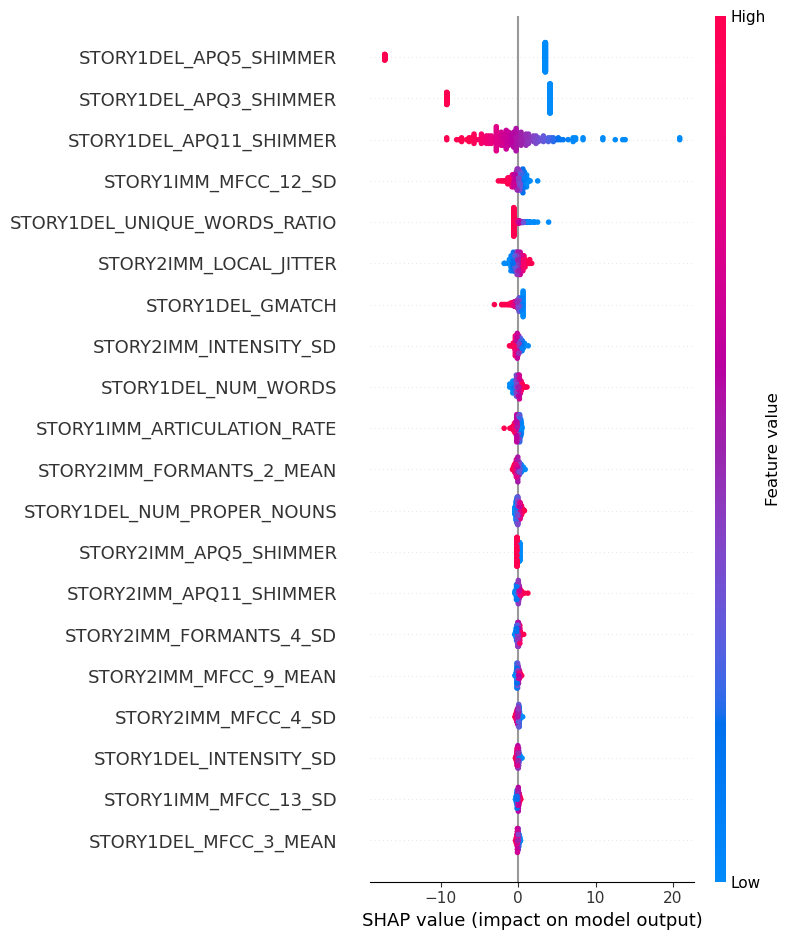


Top 20 predictors by mean |SHAP| (Lasso ScreenerSlope_perYear):
                   Predictor  MeanAbsSHAP
      STORY1DEL_APQ5_SHIMMER     5.778710
      STORY1DEL_APQ3_SHIMMER     5.624067
     STORY1DEL_APQ11_SHIMMER     3.231332
        STORY1IMM_MFCC_12_SD     0.551813
STORY1DEL_UNIQUE_WORDS_RATIO     0.512752
      STORY2IMM_LOCAL_JITTER     0.494878
            STORY1DEL_GMATCH     0.442648
      STORY2IMM_INTENSITY_SD     0.293892
         STORY1DEL_NUM_WORDS     0.270664
 STORY1IMM_ARTICULATION_RATE     0.245947
   STORY2IMM_FORMANTS_2_MEAN     0.223923
  STORY1DEL_NUM_PROPER_NOUNS     0.212146
      STORY2IMM_APQ5_SHIMMER     0.159270
     STORY2IMM_APQ11_SHIMMER     0.150203
     STORY2IMM_FORMANTS_4_SD     0.133501
       STORY2IMM_MFCC_9_MEAN     0.112042
         STORY2IMM_MFCC_4_SD     0.110053
      STORY1DEL_INTENSITY_SD     0.096707
        STORY1IMM_MFCC_13_SD     0.092530
       STORY1DEL_MFCC_3_MEAN     0.089552


In [30]:
# ============================================================
# [4.1] SHAP – Lasso regression on ScreenerSlope_perYear (FAST, NUMERIC ONLY)
#    - Uses baseline_for_reg as the source dataframe
#    - Keeps only numeric predictor columns
#    - Uses LinearExplainer for speed
# ============================================================

import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error

shap.initjs()

# ------------------------------------------------------------------
# 0. Global constants
# ------------------------------------------------------------------
RANDOM_STATE = 42
TARGET = "ScreenerSlope_perYear"

# ------------------------------------------------------------------
# 1. Source dataframe: this is what you used for Tier 2
#    (you told me this is called baseline_for_reg)
# ------------------------------------------------------------------
df_baseline_narrative = baseline_for_reg.copy()

# ------------------------------------------------------------------
# 2. Build X and y
#    - Drop the target column
#    - Keep only numeric predictor columns (no IDs, no strings)
# ------------------------------------------------------------------
X_full = df_baseline_narrative.drop(columns=[TARGET], errors="ignore")
y_reg_all = df_baseline_narrative[TARGET]

print("[4.1] SHAP – Lasso regression on ScreenerSlope_perYear")
print("X_full original shape:", X_full.shape)

# Keep only numeric columns (this drops ID-like / string columns automatically)
numeric_cols = X_full.select_dtypes(include=[np.number]).columns.tolist()
X_reg_all = X_full[numeric_cols].copy()

print("Numeric predictor columns:", len(numeric_cols))
print("X_reg_all (numeric only) shape:", X_reg_all.shape)

feature_names_reg = numeric_cols

# Drop rows with missing target
mask_nonmissing = ~y_reg_all.isna()
X_reg_all = X_reg_all.loc[mask_nonmissing]
y_reg_all = y_reg_all.loc[mask_nonmissing]

print("After dropping missing ScreenerSlope_perYear: N =", X_reg_all.shape[0])

# ------------------------------------------------------------------
# 3. Preprocess (impute + scale) and fit Lasso with alpha from Tier 2
# ------------------------------------------------------------------
alpha_reg = 0.40607212699772366  # your chosen alpha from LassoCV

preprocess = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

X_reg_proc = preprocess.fit_transform(X_reg_all)

lasso_reg = Lasso(alpha=alpha_reg, random_state=RANDOM_STATE)
lasso_reg.fit(X_reg_proc, y_reg_all)

# Simple full-data performance check (non-CV)
y_pred_full = lasso_reg.predict(X_reg_proc)
r2_full = r2_score(y_reg_all, y_pred_full)
rmse_full = mean_squared_error(y_reg_all, y_pred_full, squared=False)

print(f"Full-data R² (non-CV): {r2_full:.3f}")
print(f"Full-data RMSE (non-CV): {rmse_full:.2f}")

# ------------------------------------------------------------------
# 4. SHAP: sample background + subset to explain for speed
# ------------------------------------------------------------------
BACKGROUND_N = 100   # small background set
EXPLAIN_N = 200      # subset of points to visualize

background_reg = shap.sample(X_reg_proc, BACKGROUND_N, random_state=RANDOM_STATE)
X_explain_reg = shap.sample(X_reg_proc, EXPLAIN_N, random_state=RANDOM_STATE)

print("background_reg shape:", background_reg.shape)
print("X_explain_reg shape:", X_explain_reg.shape)

# LinearExplainer is fast and exact for linear models
explainer_reg = shap.LinearExplainer(lasso_reg, background_reg)
shap_values_reg = explainer_reg(X_explain_reg)

# ------------------------------------------------------------------
# 5. SHAP summary plot (top 20 features)
# ------------------------------------------------------------------
plt.figure(figsize=(8, 6))
shap.summary_plot(
    shap_values_reg,
    X_explain_reg,
    feature_names=feature_names_reg,
    max_display=20,
    show=False
)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 6. Tabular feature importance by mean |SHAP|
# ------------------------------------------------------------------



values_reg = shap_values_reg.values
mean_abs_shap = np.abs(values_reg).mean(axis=0)

# IMPORTANT: always use our own feature names (from the dataframe)
feature_names_for_importance = list(feature_names_reg)

# Make sure lengths match (just in case)
n_common = min(len(feature_names_for_importance), mean_abs_shap.shape[0])
feature_names_for_importance = feature_names_for_importance[:n_common]
mean_abs_shap = mean_abs_shap[:n_common]

shap_importance_reg = (
    pd.DataFrame({
        "Predictor": feature_names_for_importance,
        "MeanAbsSHAP": mean_abs_shap
    })
    .sort_values("MeanAbsSHAP", ascending=False)
)

print("\nTop 20 predictors by mean |SHAP| (Lasso ScreenerSlope_perYear):")
print(shap_importance_reg.head(20).to_string(index=False))




In [37]:
# ======================================================================
# [4.0] Common SHAP setup (run once)
# ======================================================================

import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LogisticRegressionCV
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score

RANDOM_STATE = 42

# Use this for *all* SHAP blocks
df_baseline_narrative = baseline_for_reg.copy()

TARGET_SLOPE   = "ScreenerSlope_perYear"
TARGET_FAST    = "FastRMTDecliner"
TARGET_DECL5   = "DeclinerBy5pts_0_18"
ALL_TARGETS    = [TARGET_SLOPE, TARGET_FAST, TARGET_DECL5]

# Utility to compute and print top-20 mean |SHAP| with correct feature names
def print_top20_mean_abs_shap(shap_values, feature_names, title=""):
    vals = shap_values.values

    # For classifiers: (samples, classes, features) -> take class 1
    if vals.ndim == 3:
        vals = vals[:, 1, :]  # assume binary 0/1, SHAP for class 1

    mean_abs = np.abs(vals).mean(axis=0)  # (features,)

    shap_importance = pd.DataFrame({
        "Predictor": feature_names,
        "MeanAbsSHAP": mean_abs
    }).sort_values("MeanAbsSHAP", ascending=False)

    print(f"\nTop 20 predictors by mean |SHAP| – {title}")
    print(shap_importance.head(20).to_string(index=False))
    return shap_importance




# ------------------------------------------------------------------
# Helper to extract numeric X and feature names for a given target
# ------------------------------------------------------------------
def get_numeric_X_and_feature_names(df, target_col, extra_drop_cols=None):
    if extra_drop_cols is None:
        extra_drop_cols = []
    drop_cols = [target_col] + extra_drop_cols
    drop_cols = [c for c in drop_cols if c in df.columns]

    X_df = df.drop(columns=drop_cols, errors="ignore")
    # Keep only numeric predictors
    X_df = X_df.select_dtypes(include=[np.number])
    feature_names = list(X_df.columns)
    return X_df, feature_names


[4.2] SHAP – L1-logistic on FastRMTDecliner
X_fast_num shape: (4313, 206)
Class balance: [3022 1291]
Full-data AUC (FastRMTDecliner): 0.67
background_fast shape: (100, 206)
X_explain_fast shape: (200, 206)


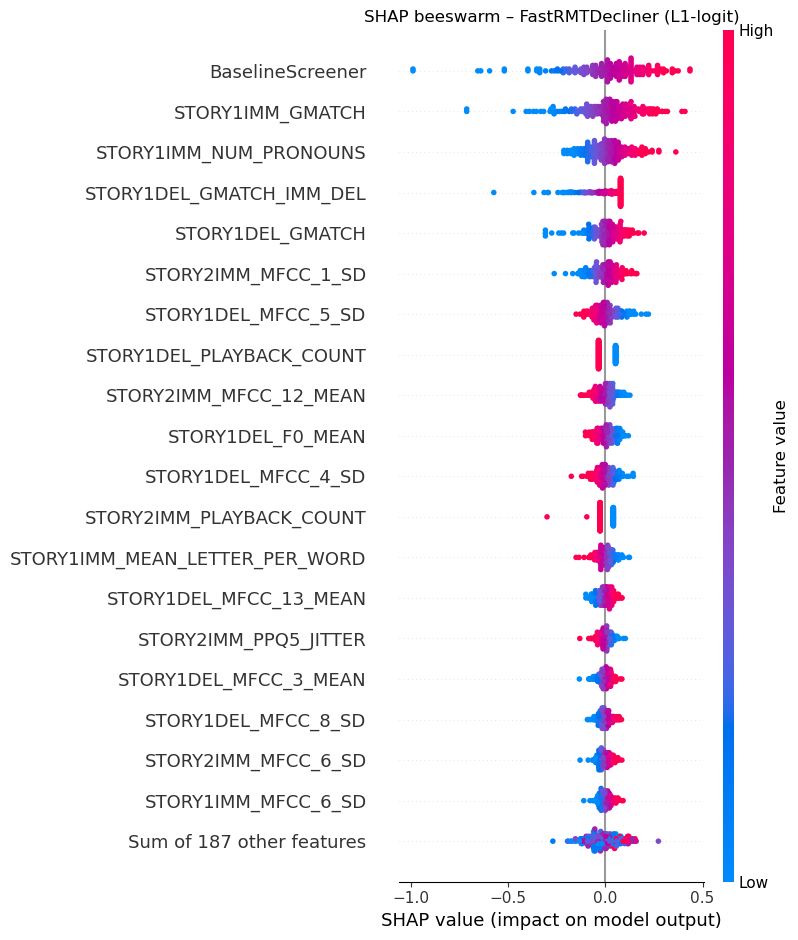


Top 20 predictors by mean |SHAP| – FastRMTDecliner (L1-logit)
                     Predictor  MeanAbsSHAP
              BaselineScreener     0.152881
              STORY1IMM_GMATCH     0.123262
        STORY1IMM_NUM_PRONOUNS     0.084465
      STORY1DEL_GMATCH_IMM_DEL     0.074231
              STORY1DEL_GMATCH     0.060908
           STORY2IMM_MFCC_1_SD     0.053104
           STORY1DEL_MFCC_5_SD     0.049352
      STORY1DEL_PLAYBACK_COUNT     0.041515
        STORY2IMM_MFCC_12_MEAN     0.037470
             STORY1DEL_F0_MEAN     0.037005
           STORY1DEL_MFCC_4_SD     0.035478
      STORY2IMM_PLAYBACK_COUNT     0.034099
STORY1IMM_MEAN_LETTER_PER_WORD     0.031366
        STORY1DEL_MFCC_13_MEAN     0.028832
         STORY2IMM_PPQ5_JITTER     0.025553
         STORY1DEL_MFCC_3_MEAN     0.024676
           STORY1DEL_MFCC_8_SD     0.024457
           STORY2IMM_MFCC_6_SD     0.023708
           STORY1IMM_MFCC_6_SD     0.023283
         STORY1IMM_NUM_ADVERBS     0.020531


In [39]:
# ======================================================================
# [4.2] SHAP – L1-logistic on FastRMTDecliner
# ======================================================================

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score

print("[4.2] SHAP – L1-logistic on FastRMTDecliner")

# 1) X, y
X_fast_all = df_baseline_narrative.drop(columns=ALL_TARGETS, errors="ignore")
y_fast_all = df_baseline_narrative["FastRMTDecliner"].astype(int)

# numeric-only + drop all-NaN numeric columns
numeric_cols_fast_all = X_fast_all.select_dtypes(include=[np.number]).columns
numeric_cols_fast = [
    c for c in numeric_cols_fast_all
    if not X_fast_all[c].isna().all()
]
X_fast_num = X_fast_all[numeric_cols_fast].copy()

print("X_fast_num shape:", X_fast_num.shape)
print("Class balance:", np.bincount(y_fast_all))

# 2) Impute + scale (no Pipeline so we can control columns)
imp_fast = SimpleImputer(strategy="median")
X_fast_imp = imp_fast.fit_transform(X_fast_num)

scaler_fast = StandardScaler()
X_fast_proc = scaler_fast.fit_transform(X_fast_imp)

X_fast_proc_df = pd.DataFrame(
    X_fast_proc,
    index=X_fast_num.index,
    columns=numeric_cols_fast
)

# 3) Fit L1-logistic with CV
logit_fast = LogisticRegressionCV(
    Cs=10,
    cv=5,
    penalty="l1",
    solver="saga",
    scoring="roc_auc",
    n_jobs=-1,
    refit=True,
    random_state=RANDOM_STATE,
    max_iter=5000
)
logit_fast.fit(X_fast_proc_df, y_fast_all)

y_fast_proba = logit_fast.predict_proba(X_fast_proc_df)[:, 1]
auc_fast_full = roc_auc_score(y_fast_all, y_fast_proba)
print("Full-data AUC (FastRMTDecliner):", round(auc_fast_full, 3))

# 4) Background + explain sets
background_fast = shap.sample(X_fast_proc_df, 100, random_state=RANDOM_STATE)
X_explain_fast  = shap.sample(X_fast_proc_df, 200, random_state=RANDOM_STATE)

print("background_fast shape:", background_fast.shape)
print("X_explain_fast shape:", X_explain_fast.shape)

# 5) SHAP
explainer_fast = shap.Explainer(logit_fast, background_fast)
shap_values_fast = explainer_fast(X_explain_fast)

# 6) Beeswarm
plt.figure(figsize=(8, 6))
shap.plots.beeswarm(
    shap_values_fast,
    max_display=20,
    show=False,
    color_bar=True,
)
plt.title("SHAP beeswarm – FastRMTDecliner (L1-logit)")
plt.tight_layout()
plt.show()

# 7) Tabular importance
shap_importance_fast = print_top20_mean_abs_shap(
    shap_values_fast,
    feature_names=X_fast_proc_df.columns,
    title="FastRMTDecliner (L1-logit)"
)


[4.3] SHAP – L1-logistic on DeclinerBy5pts_0_18
X_decl5_num shape: (4313, 206)
Class balance: [3600  713]
Full-data AUC (DeclinerBy5pts_0_18): 0.657
background_decl5 shape: (100, 206)
X_explain_decl5 shape: (200, 206)


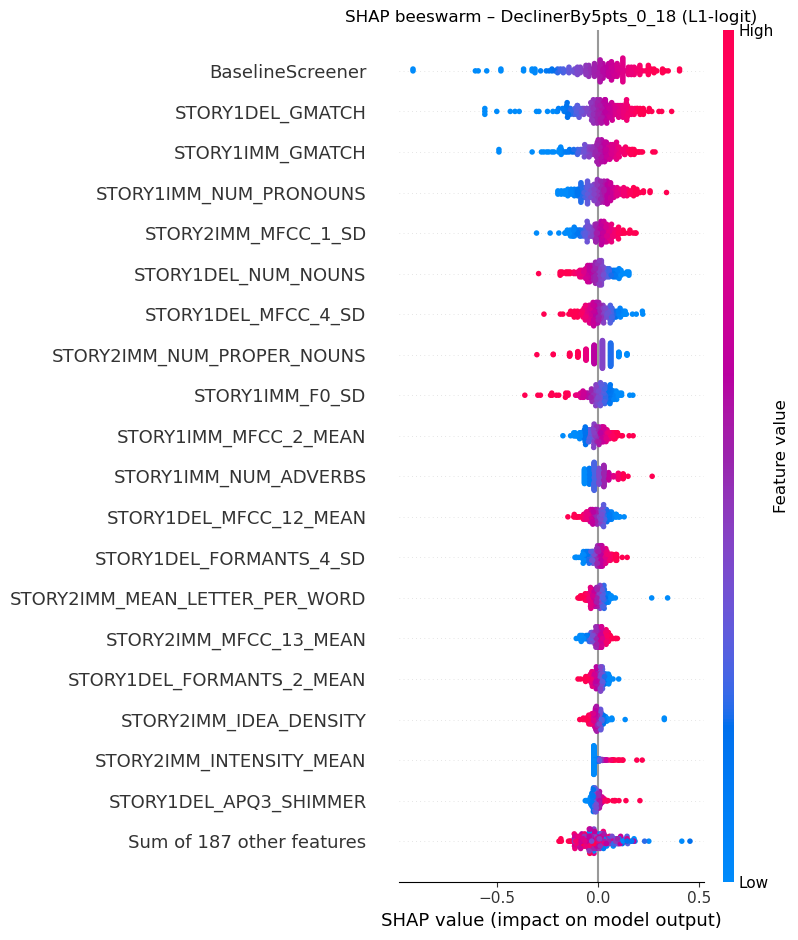


Top 20 predictors by mean |SHAP| – DeclinerBy5pts_0_18 (L1-logit)
                     Predictor  MeanAbsSHAP
              BaselineScreener     0.141991
              STORY1DEL_GMATCH     0.111172
              STORY1IMM_GMATCH     0.085074
        STORY1IMM_NUM_PRONOUNS     0.079116
           STORY2IMM_MFCC_1_SD     0.061725
           STORY1DEL_NUM_NOUNS     0.055307
           STORY1DEL_MFCC_4_SD     0.054514
    STORY2IMM_NUM_PROPER_NOUNS     0.053887
               STORY1IMM_F0_SD     0.053634
         STORY1IMM_MFCC_2_MEAN     0.044539
         STORY1IMM_NUM_ADVERBS     0.042329
        STORY1DEL_MFCC_12_MEAN     0.039192
       STORY1DEL_FORMANTS_4_SD     0.036885
STORY2IMM_MEAN_LETTER_PER_WORD     0.031567
        STORY2IMM_MFCC_13_MEAN     0.031048
     STORY1DEL_FORMANTS_2_MEAN     0.025304
        STORY2IMM_IDEA_DENSITY     0.025140
      STORY2IMM_INTENSITY_MEAN     0.021911
        STORY1DEL_APQ3_SHIMMER     0.020008
           STORY1DEL_MFCC_5_SD     0.018791


In [40]:
# ======================================================================
# [4.3] SHAP – L1-logistic on DeclinerBy5pts_0_18
# ======================================================================

print("[4.3] SHAP – L1-logistic on DeclinerBy5pts_0_18")

# 1) X, y
X_decl5_all = df_baseline_narrative.drop(columns=ALL_TARGETS, errors="ignore")
y_decl5_all = df_baseline_narrative["DeclinerBy5pts_0_18"].astype(int)

# numeric-only + drop all-NaN numeric columns
numeric_cols_decl5_all = X_decl5_all.select_dtypes(include=[np.number]).columns
numeric_cols_decl5 = [
    c for c in numeric_cols_decl5_all
    if not X_decl5_all[c].isna().all()
]
X_decl5_num = X_decl5_all[numeric_cols_decl5].copy()

print("X_decl5_num shape:", X_decl5_num.shape)
print("Class balance:", np.bincount(y_decl5_all))

# 2) Impute + scale
imp_decl5 = SimpleImputer(strategy="median")
X_decl5_imp = imp_decl5.fit_transform(X_decl5_num)

scaler_decl5 = StandardScaler()
X_decl5_proc = scaler_decl5.fit_transform(X_decl5_imp)

X_decl5_proc_df = pd.DataFrame(
    X_decl5_proc,
    index=X_decl5_num.index,
    columns=numeric_cols_decl5
)

# 3) Fit L1-logistic
logit_decl5 = LogisticRegressionCV(
    Cs=10,
    cv=5,
    penalty="l1",
    solver="saga",
    scoring="roc_auc",
    n_jobs=-1,
    refit=True,
    random_state=RANDOM_STATE,
    max_iter=5000
)
logit_decl5.fit(X_decl5_proc_df, y_decl5_all)

y_decl5_proba = logit_decl5.predict_proba(X_decl5_proc_df)[:, 1]
auc_decl5_full = roc_auc_score(y_decl5_all, y_decl5_proba)
print("Full-data AUC (DeclinerBy5pts_0_18):", round(auc_decl5_full, 3))

# 4) Background + explain sets
background_decl5 = shap.sample(X_decl5_proc_df, 100, random_state=RANDOM_STATE)
X_explain_decl5  = shap.sample(X_decl5_proc_df, 200, random_state=RANDOM_STATE)

print("background_decl5 shape:", background_decl5.shape)
print("X_explain_decl5 shape:", X_explain_decl5.shape)

# 5) SHAP
explainer_decl5 = shap.Explainer(logit_decl5, background_decl5)
shap_values_decl5 = explainer_decl5(X_explain_decl5)

# 6) Beeswarm
plt.figure(figsize=(8, 6))
shap.plots.beeswarm(
    shap_values_decl5,
    max_display=20,
    show=False,
    color_bar=True,
)
plt.title("SHAP beeswarm – DeclinerBy5pts_0_18 (L1-logit)")
plt.tight_layout()
plt.show()

# 7) Tabular importance
shap_importance_decl5 = print_top20_mean_abs_shap(
    shap_values_decl5,
    feature_names=X_decl5_proc_df.columns,
    title="DeclinerBy5pts_0_18 (L1-logit)"
)


[4.4] SHAP – MLP regression on ScreenerSlope_perYear
X_mlp_reg_num shape: (4313, 206)
Full-data R² (MLP): 0.95
Full-data RMSE (MLP): 5.13
background_mlp_reg_df shape: (40, 206)
X_explain_mlp_reg_df shape: (80, 206)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(


  0%|          | 0/80 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPRegressor was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid featu

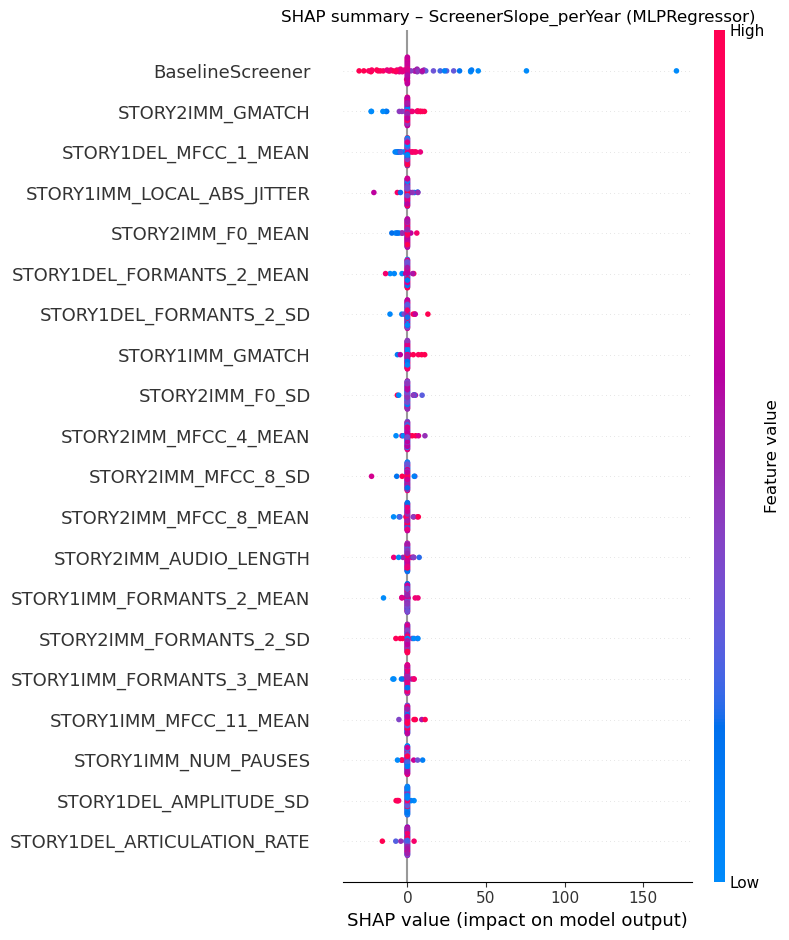


Top 20 predictors by mean |SHAP| – ScreenerSlope_perYear (MLPRegressor):
                  Predictor  MeanAbsSHAP
           BaselineScreener    12.076464
           STORY2IMM_GMATCH     2.006855
      STORY1DEL_MFCC_1_MEAN     0.936110
 STORY1IMM_LOCAL_ABS_JITTER     0.687419
          STORY2IMM_F0_MEAN     0.653019
  STORY1DEL_FORMANTS_2_MEAN     0.570265
    STORY1DEL_FORMANTS_2_SD     0.537809
           STORY1IMM_GMATCH     0.537074
            STORY2IMM_F0_SD     0.535968
      STORY2IMM_MFCC_4_MEAN     0.528150
        STORY2IMM_MFCC_8_SD     0.525113
      STORY2IMM_MFCC_8_MEAN     0.511877
     STORY2IMM_AUDIO_LENGTH     0.489306
  STORY1IMM_FORMANTS_2_MEAN     0.443921
    STORY2IMM_FORMANTS_2_SD     0.440207
  STORY1IMM_FORMANTS_3_MEAN     0.439490
     STORY1IMM_MFCC_11_MEAN     0.438432
       STORY1IMM_NUM_PAUSES     0.438048
     STORY1DEL_AMPLITUDE_SD     0.412159
STORY1DEL_ARTICULATION_RATE     0.409695


In [43]:
# ======================================================================
# [4.4] SHAP – MLP regression on ScreenerSlope_perYear (KernelExplainer)
# ======================================================================

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error

print("[4.4] SHAP – MLP regression on ScreenerSlope_perYear")

# 1) X, y
X_mlp_reg_all = df_baseline_narrative.drop(columns=ALL_TARGETS, errors="ignore")
y_mlp_reg_all = df_baseline_narrative["ScreenerSlope_perYear"]

mask_mlp_reg = y_mlp_reg_all.notna()
X_mlp_reg_all = X_mlp_reg_all.loc[mask_mlp_reg].copy()
y_mlp_reg_all = y_mlp_reg_all.loc[mask_mlp_reg].copy()

# numeric-only + drop all-NaN numeric columns
numeric_cols_mlp_reg_all = X_mlp_reg_all.select_dtypes(include=[np.number]).columns
numeric_cols_mlp_reg = [
    c for c in numeric_cols_mlp_reg_all
    if not X_mlp_reg_all[c].isna().all()
]
X_mlp_reg_num = X_mlp_reg_all[numeric_cols_mlp_reg].copy()

print("X_mlp_reg_num shape:", X_mlp_reg_num.shape)

# 2) Impute + scale
imp_mlp_reg = SimpleImputer(strategy="median")
X_mlp_reg_imp = imp_mlp_reg.fit_transform(X_mlp_reg_num)

scaler_mlp_reg = StandardScaler()
X_mlp_reg_proc = scaler_mlp_reg.fit_transform(X_mlp_reg_imp)

X_mlp_reg_proc_df = pd.DataFrame(
    X_mlp_reg_proc,
    index=X_mlp_reg_num.index,
    columns=numeric_cols_mlp_reg
)

# 3) Fit MLPRegressor (same as Tier 3)
mlp_reg = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    alpha=1e-3,
    max_iter=500,
    random_state=RANDOM_STATE
)
mlp_reg.fit(X_mlp_reg_proc_df, y_mlp_reg_all)

y_mlp_reg_pred = mlp_reg.predict(X_mlp_reg_proc_df)
r2_mlp_full = r2_score(y_mlp_reg_all, y_mlp_reg_pred)
rmse_mlp_full = mean_squared_error(y_mlp_reg_all, y_mlp_reg_pred, squared=False)
print("Full-data R² (MLP):", round(r2_mlp_full, 3))
print("Full-data RMSE (MLP):", round(rmse_mlp_full, 2))

# 4) Background + explain sets (keep small – KernelExplainer is heavier)
background_mlp_reg_df = shap.sample(X_mlp_reg_proc_df, 40, random_state=RANDOM_STATE)
X_explain_mlp_reg_df  = shap.sample(X_mlp_reg_proc_df, 80,  random_state=RANDOM_STATE)

print("background_mlp_reg_df shape:", background_mlp_reg_df.shape)
print("X_explain_mlp_reg_df shape:", X_explain_mlp_reg_df.shape)

background_mlp_reg = background_mlp_reg_df.values
X_explain_mlp_reg  = X_explain_mlp_reg_df.values

# 5) SHAP – KernelExplainer on mlp_reg.predict
explainer_mlp_reg = shap.KernelExplainer(
    lambda x: mlp_reg.predict(x),
    background_mlp_reg
)

# nsamples controls runtime vs accuracy
shap_values_mlp_reg = explainer_mlp_reg.shap_values(
    X_explain_mlp_reg,
    nsamples=100
)   # can bump to 200 if you have patience

# 6) Summary plot (beeswarm-like)
plt.figure(figsize=(8, 6))
shap.summary_plot(
    shap_values_mlp_reg,
    X_explain_mlp_reg_df,
    feature_names=X_mlp_reg_proc_df.columns,
    max_display=20,
    show=False
)
plt.title("SHAP summary – ScreenerSlope_perYear (MLPRegressor)")
plt.tight_layout()
plt.show()

# 7) Tabular importance – top 20 mean |SHAP|
mean_abs_shap_mlp_reg = np.mean(np.abs(shap_values_mlp_reg), axis=0)
shap_importance_mlp_reg = (
    pd.DataFrame({
        "Predictor": X_mlp_reg_proc_df.columns,
        "MeanAbsSHAP": mean_abs_shap_mlp_reg
    })
    .sort_values("MeanAbsSHAP", ascending=False)
)

print("\nTop 20 predictors by mean |SHAP| – ScreenerSlope_perYear (MLPRegressor):")
print(shap_importance_mlp_reg.head(20).to_string(index=False))


[4.5] SHAP – MLP classifier on FastRMTDecliner
X_mlp_fast_num shape: (4313, 206)
Class balance: [3022 1291]
Full-data AUC (FastRMTDecliner, MLP): 1.0
background_mlp_fast_df shape: (40, 206)
X_explain_mlp_fast_df shape: (80, 206)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


  0%|          | 0/80 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid 

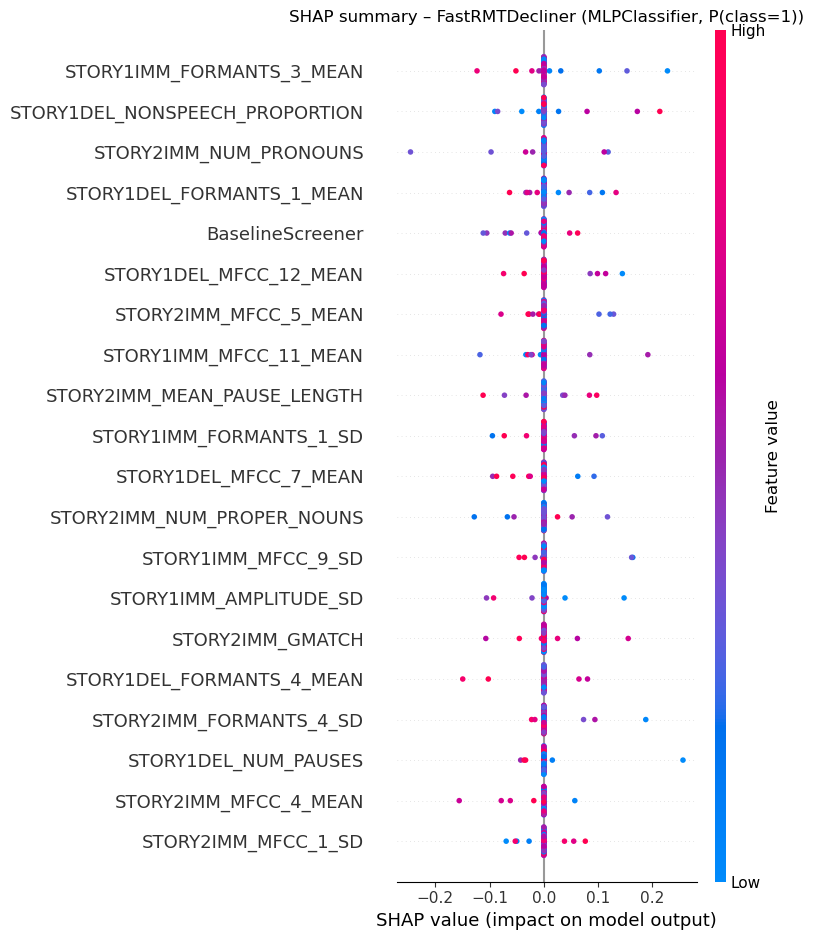


Top 20 predictors by mean |SHAP| – FastRMTDecliner (MLPClassifier):
                     Predictor  MeanAbsSHAP
     STORY1IMM_FORMANTS_3_MEAN     0.009190
STORY1DEL_NONSPEECH_PROPORTION     0.008985
        STORY2IMM_NUM_PRONOUNS     0.007843
     STORY1DEL_FORMANTS_1_MEAN     0.007058
              BaselineScreener     0.007033
        STORY1DEL_MFCC_12_MEAN     0.006923
         STORY2IMM_MFCC_5_MEAN     0.006569
        STORY1IMM_MFCC_11_MEAN     0.006359
   STORY2IMM_MEAN_PAUSE_LENGTH     0.005909
       STORY1IMM_FORMANTS_1_SD     0.005753
         STORY1DEL_MFCC_7_MEAN     0.005586
    STORY2IMM_NUM_PROPER_NOUNS     0.005569
           STORY1IMM_MFCC_9_SD     0.005322
        STORY1IMM_AMPLITUDE_SD     0.005144
              STORY2IMM_GMATCH     0.004995
     STORY1DEL_FORMANTS_4_MEAN     0.004967
       STORY2IMM_FORMANTS_4_SD     0.004933
          STORY1DEL_NUM_PAUSES     0.004816
         STORY2IMM_MFCC_4_MEAN     0.004652
           STORY2IMM_MFCC_1_SD     0.004612


In [44]:
# ======================================================================
# [4.5] SHAP – MLP classifier on FastRMTDecliner (KernelExplainer)
# ======================================================================

from sklearn.neural_network import MLPClassifier

print("[4.5] SHAP – MLP classifier on FastRMTDecliner")

# 1) X, y
X_mlp_fast_all = df_baseline_narrative.drop(columns=ALL_TARGETS, errors="ignore")
y_mlp_fast_all = df_baseline_narrative["FastRMTDecliner"].astype(int)

numeric_cols_mlp_fast_all = X_mlp_fast_all.select_dtypes(include=[np.number]).columns
numeric_cols_mlp_fast = [
    c for c in numeric_cols_mlp_fast_all
    if not X_mlp_fast_all[c].isna().all()
]
X_mlp_fast_num = X_mlp_fast_all[numeric_cols_mlp_fast].copy()

print("X_mlp_fast_num shape:", X_mlp_fast_num.shape)
print("Class balance:", np.bincount(y_mlp_fast_all))

# 2) Impute + scale
imp_mlp_fast = SimpleImputer(strategy="median")
X_mlp_fast_imp = imp_mlp_fast.fit_transform(X_mlp_fast_num)

scaler_mlp_fast = StandardScaler()
X_mlp_fast_proc = scaler_mlp_fast.fit_transform(X_mlp_fast_imp)

X_mlp_fast_proc_df = pd.DataFrame(
    X_mlp_fast_proc,
    index=X_mlp_fast_num.index,
    columns=numeric_cols_mlp_fast
)

# 3) Fit MLPClassifier
mlp_fast = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    alpha=1e-3,
    max_iter=500,
    random_state=RANDOM_STATE
)
mlp_fast.fit(X_mlp_fast_proc_df, y_mlp_fast_all)

y_mlp_fast_proba = mlp_fast.predict_proba(X_mlp_fast_proc_df)[:, 1]
auc_mlp_fast_full = roc_auc_score(y_mlp_fast_all, y_mlp_fast_proba)
print("Full-data AUC (FastRMTDecliner, MLP):", round(auc_mlp_fast_full, 3))

# 4) Background + explain sets
background_mlp_fast_df = shap.sample(X_mlp_fast_proc_df, 40, random_state=RANDOM_STATE)
X_explain_mlp_fast_df  = shap.sample(X_mlp_fast_proc_df, 80,  random_state=RANDOM_STATE)

print("background_mlp_fast_df shape:", background_mlp_fast_df.shape)
print("X_explain_mlp_fast_df shape:", X_explain_mlp_fast_df.shape)

background_mlp_fast = background_mlp_fast_df.values
X_explain_mlp_fast  = X_explain_mlp_fast_df.values

# 5) SHAP – KernelExplainer on probability of class 1
explainer_mlp_fast = shap.KernelExplainer(
    lambda x: mlp_fast.predict_proba(x)[:, 1],
    background_mlp_fast
)

shap_values_mlp_fast = explainer_mlp_fast.shap_values(
    X_explain_mlp_fast,
    nsamples=100
)

# 6) Summary plot for positive-class SHAP
plt.figure(figsize=(8, 6))
shap.summary_plot(
    shap_values_mlp_fast,
    X_explain_mlp_fast_df,
    feature_names=X_mlp_fast_proc_df.columns,
    max_display=20,
    show=False
)
plt.title("SHAP summary – FastRMTDecliner (MLPClassifier, P(class=1))")
plt.tight_layout()
plt.show()

# 7) Tabular importance
mean_abs_shap_mlp_fast = np.mean(np.abs(shap_values_mlp_fast), axis=0)
shap_importance_mlp_fast = (
    pd.DataFrame({
        "Predictor": X_mlp_fast_proc_df.columns,
        "MeanAbsSHAP": mean_abs_shap_mlp_fast
    })
    .sort_values("MeanAbsSHAP", ascending=False)
)

print("\nTop 20 predictors by mean |SHAP| – FastRMTDecliner (MLPClassifier):")
print(shap_importance_mlp_fast.head(20).to_string(index=False))


[4.6] SHAP – MLP classifier on DeclinerBy5pts_0_18
X_mlp_decl5_num shape: (4313, 206)
Class balance: [3600  713]
Full-data AUC (DeclinerBy5pts_0_18, MLP): 1.0
background_mlp_decl5_df shape: (40, 206)
X_explain_mlp_decl5_df shape: (80, 206)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(


  0%|          | 0/80 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid 

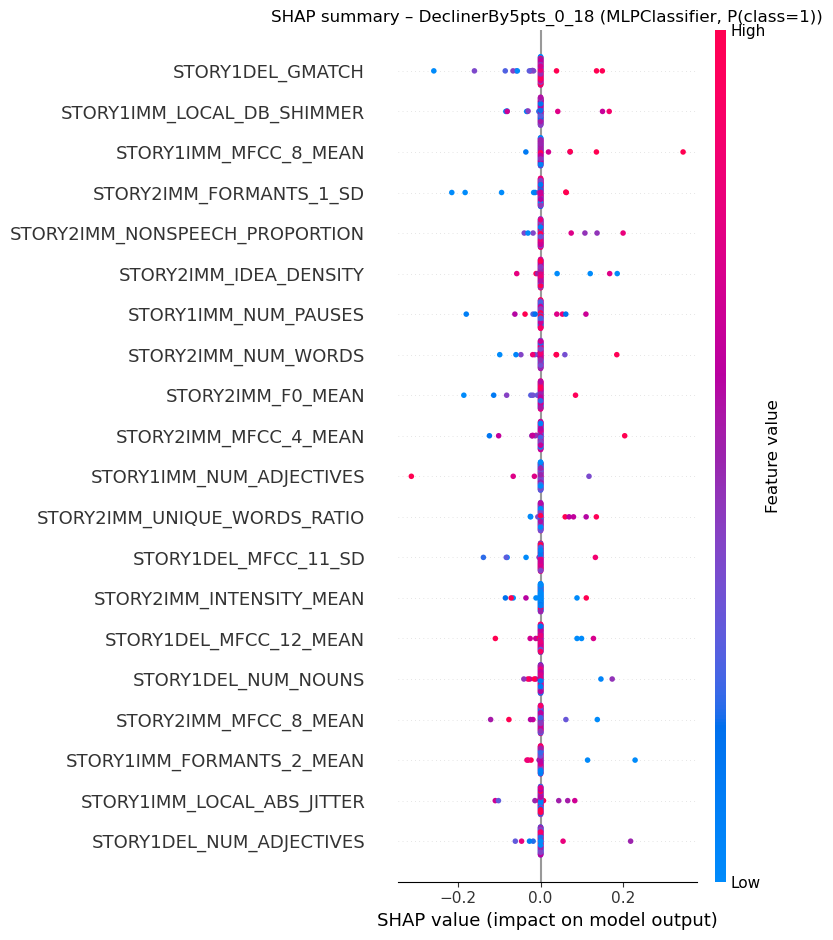


Top 20 predictors by mean |SHAP| – DeclinerBy5pts_0_18 (MLPClassifier):
                     Predictor  MeanAbsSHAP
              STORY1DEL_GMATCH     0.013749
    STORY1IMM_LOCAL_DB_SHIMMER     0.008835
         STORY1IMM_MFCC_8_MEAN     0.008492
       STORY2IMM_FORMANTS_1_SD     0.008133
STORY2IMM_NONSPEECH_PROPORTION     0.007594
        STORY2IMM_IDEA_DENSITY     0.007376
          STORY1IMM_NUM_PAUSES     0.007194
           STORY2IMM_NUM_WORDS     0.007073
             STORY2IMM_F0_MEAN     0.006527
         STORY2IMM_MFCC_4_MEAN     0.006444
      STORY1IMM_NUM_ADJECTIVES     0.006407
  STORY2IMM_UNIQUE_WORDS_RATIO     0.006375
          STORY1DEL_MFCC_11_SD     0.005939
      STORY2IMM_INTENSITY_MEAN     0.005915
        STORY1DEL_MFCC_12_MEAN     0.005887
           STORY1DEL_NUM_NOUNS     0.005559
         STORY2IMM_MFCC_8_MEAN     0.005501
     STORY1IMM_FORMANTS_2_MEAN     0.005414
    STORY1IMM_LOCAL_ABS_JITTER     0.005359
      STORY1DEL_NUM_ADJECTIVES     0.005317


In [45]:
# ======================================================================
# [4.6] SHAP – MLP classifier on DeclinerBy5pts_0_18 (KernelExplainer)
# ======================================================================

print("[4.6] SHAP – MLP classifier on DeclinerBy5pts_0_18")

# 1) X, y
X_mlp_decl5_all = df_baseline_narrative.drop(columns=ALL_TARGETS, errors="ignore")
y_mlp_decl5_all = df_baseline_narrative["DeclinerBy5pts_0_18"].astype(int)

numeric_cols_mlp_decl5_all = X_mlp_decl5_all.select_dtypes(include=[np.number]).columns
numeric_cols_mlp_decl5 = [
    c for c in numeric_cols_mlp_decl5_all
    if not X_mlp_decl5_all[c].isna().all()
]
X_mlp_decl5_num = X_mlp_decl5_all[numeric_cols_mlp_decl5].copy()

print("X_mlp_decl5_num shape:", X_mlp_decl5_num.shape)
print("Class balance:", np.bincount(y_mlp_decl5_all))

# 2) Impute + scale
imp_mlp_decl5 = SimpleImputer(strategy="median")
X_mlp_decl5_imp = imp_mlp_decl5.fit_transform(X_mlp_decl5_num)

scaler_mlp_decl5 = StandardScaler()
X_mlp_decl5_proc = scaler_mlp_decl5.fit_transform(X_mlp_decl5_imp)

X_mlp_decl5_proc_df = pd.DataFrame(
    X_mlp_decl5_proc,
    index=X_mlp_decl5_num.index,
    columns=numeric_cols_mlp_decl5
)

# 3) Fit MLPClassifier
mlp_decl5 = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    alpha=1e-3,
    max_iter=500,
    random_state=RANDOM_STATE
)
mlp_decl5.fit(X_mlp_decl5_proc_df, y_mlp_decl5_all)

y_mlp_decl5_proba = mlp_decl5.predict_proba(X_mlp_decl5_proc_df)[:, 1]
auc_mlp_decl5_full = roc_auc_score(y_mlp_decl5_all, y_mlp_decl5_proba)
print("Full-data AUC (DeclinerBy5pts_0_18, MLP):", round(auc_mlp_decl5_full, 3))

# 4) Background + explain sets
background_mlp_decl5_df = shap.sample(X_mlp_decl5_proc_df, 40, random_state=RANDOM_STATE)
X_explain_mlp_decl5_df  = shap.sample(X_mlp_decl5_proc_df, 80,  random_state=RANDOM_STATE)

print("background_mlp_decl5_df shape:", background_mlp_decl5_df.shape)
print("X_explain_mlp_decl5_df shape:", X_explain_mlp_decl5_df.shape)

background_mlp_decl5 = background_mlp_decl5_df.values
X_explain_mlp_decl5  = X_explain_mlp_decl5_df.values

# 5) SHAP – KernelExplainer on probability of class 1
explainer_mlp_decl5 = shap.KernelExplainer(
    lambda x: mlp_decl5.predict_proba(x)[:, 1],
    background_mlp_decl5
)

shap_values_mlp_decl5 = explainer_mlp_decl5.shap_values(
    X_explain_mlp_decl5,
    nsamples=100
)

# 6) Summary plot
plt.figure(figsize=(8, 6))
shap.summary_plot(
    shap_values_mlp_decl5,
    X_explain_mlp_decl5_df,
    feature_names=X_mlp_decl5_proc_df.columns,
    max_display=20,
    show=False
)
plt.title("SHAP summary – DeclinerBy5pts_0_18 (MLPClassifier, P(class=1))")
plt.tight_layout()
plt.show()

# 7) Tabular importance
mean_abs_shap_mlp_decl5 = np.mean(np.abs(shap_values_mlp_decl5), axis=0)
shap_importance_mlp_decl5 = (
    pd.DataFrame({
        "Predictor": X_mlp_decl5_proc_df.columns,
        "MeanAbsSHAP": mean_abs_shap_mlp_decl5
    })
    .sort_values("MeanAbsSHAP", ascending=False)
)

print("\nTop 20 predictors by mean |SHAP| – DeclinerBy5pts_0_18 (MLPClassifier):")
print(shap_importance_mlp_decl5.head(20).to_string(index=False))


## ECOG Analysis 

In [47]:
import pandas as pd

# 1. Read the CSV into a DataFrame
csv_path = "adnidata/RMT_ECOG12PT_01Feb2026.csv"
df_ecog = pd.read_csv(csv_path)

# (Optional but usually sensible) restrict to ADNI4 RMT phase
df_ecog = df_ecog[df_ecog["RMT_PHASE"] == "ADNI4"].copy()

# 2. Helper: keep only rows for subjects that have BOTH timepoints t1 and t2
def subset_subjects_with_timepoints(df, t1, t2):
    """
    Return a filtered df containing only subjects (ADNIOnlineID)
    who have BOTH timepoints t1 and t2.
    """
    # For each subject, check if both timepoints appear in their rows
    has_both = df.groupby("ADNIOnlineID")["RMT_Timepoint"].transform(
        lambda tp: {t1, t2}.issubset(set(tp.dropna()))
    )
    return df[has_both].copy()

# 3. DataFrame with subjects who have BOTH m00 and m06
df_m00_m06 = subset_subjects_with_timepoints(df_ecog, "m00", "m06")

# 4. DataFrame with subjects who have BOTH m06 and m12
df_m06_m12 = subset_subjects_with_timepoints(df_ecog, "m06", "m12")

# 5. Number of unique subjects in each derived DataFrame
n_subj_m00_m06 = df_m00_m06["ADNIOnlineID"].nunique()
n_subj_m06_m12 = df_m06_m12["ADNIOnlineID"].nunique()

print(f"Unique subjects with BOTH m00 and m06: {n_subj_m00_m06}")
print(f"Unique subjects with BOTH m06 and m12: {n_subj_m06_m12}")


Unique subjects with BOTH m00 and m06: 5445
Unique subjects with BOTH m06 and m12: 1965


In [56]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

# ------------------------------------------------------------
# 1. Parameters
# ------------------------------------------------------------
ecog_csv_path = "adnidata/RMT_ECOG12PT_01Feb2026.csv"
ecog_item_cols = [f"RMT_ecogpt{i}" for i in range(1, 13)]
decline_threshold = 2  # >= 2 point worsening = "higher risk" group

# ------------------------------------------------------------
# 2. Read ECOG data
# ------------------------------------------------------------
df_ecog = pd.read_csv(ecog_csv_path)

# RMT features dataframe (assumes `rmt` already exists in your session)
df_rmt_all = rmt.copy()

# ------------------------------------------------------------
# 3. ECOG: compute total and longitudinal deltas
# ------------------------------------------------------------

df_ecog = df_ecog.copy()
df_ecog["RMT_Timepoint"] = df_ecog["RMT_Timepoint"].str.lower().str.strip()

# Total ECOG at each RMT timepoint (row-wise sum of the 12 items)
df_ecog["TOTAL_ECOG"] = df_ecog[ecog_item_cols].sum(axis=1, min_count=1)

# Pivot to subject x timepoint
pivot_totals = df_ecog.pivot_table(
    index="ADNIOnlineID",
    columns="RMT_Timepoint",
    values="TOTAL_ECOG",
    aggfunc="mean"
)

# ------------------------
# m00 -> m06
# ------------------------
mask_00_06 = pivot_totals["m00"].notna() & pivot_totals["m06"].notna()
pivot_00_06 = pivot_totals.loc[mask_00_06, ["m00", "m06"]].copy()
pivot_00_06["ECOG_delta_00_06"] = pivot_00_06["m06"] - pivot_00_06["m00"]
pivot_00_06["ECOG_label_00_06"] = (pivot_00_06["ECOG_delta_00_06"] >= decline_threshold).astype(int)

print("[m00 -> m06] Number of subjects:", pivot_00_06.shape[0])
print("[m00 -> m06] Class balance (0=preserved, 1=higher-risk):")
print(pivot_00_06["ECOG_label_00_06"].value_counts())

# ------------------------
# m06 -> m12
# ------------------------
mask_06_12 = pivot_totals["m06"].notna() & pivot_totals["m12"].notna()
pivot_06_12 = pivot_totals.loc[mask_06_12, ["m06", "m12"]].copy()
pivot_06_12["ECOG_delta_06_12"] = pivot_06_12["m12"] - pivot_06_12["m06"]
pivot_06_12["ECOG_label_06_12"] = (pivot_06_12["ECOG_delta_06_12"] >= decline_threshold).astype(int)

print("\n[m06 -> m12] Number of subjects:", pivot_06_12.shape[0])
print("[m06 -> m12] Class balance (0=preserved, 1=higher-risk):")
print(pivot_06_12["ECOG_label_06_12"].value_counts())

# ------------------------------------------------------------
# 4. Prepare RMT features (numeric only, no screener-like cols)
# ------------------------------------------------------------

df_rmt_all = df_rmt_all.copy()
df_rmt_all["RMT_Timepoint"] = df_rmt_all["RMT_Timepoint"].str.lower().str.strip()

# Filter to relevant timepoints
df_rmt_m00 = df_rmt_all[df_rmt_all["RMT_Timepoint"] == "m00"].copy()
df_rmt_m06 = df_rmt_all[df_rmt_all["RMT_Timepoint"] == "m06"].copy()

def drop_screener_cols(df):
    screener_cols = [c for c in df.columns if "SCREENER" in c.upper()]
    return df.drop(columns=screener_cols, errors="ignore")

df_rmt_m00 = drop_screener_cols(df_rmt_m00)
df_rmt_m06 = drop_screener_cols(df_rmt_m06)

# Only numeric columns
num_cols_m00 = df_rmt_m00.select_dtypes(include=[np.number]).columns.tolist()
num_cols_m06 = df_rmt_m06.select_dtypes(include=[np.number]).columns.tolist()

# Use common numeric features at m00 and m06
feature_cols = sorted(list(set(num_cols_m00) & set(num_cols_m06)))
print("\nNumber of RMT baseline numeric features used (no screener):", len(feature_cols))

# ------------------------------------------------------------
# 5. Merge ECOG labels with RMT features
# ------------------------------------------------------------

# m00 -> m06: baseline features from m00
df_00_06_model = (
    df_rmt_m00[["ADNIOnlineID"] + feature_cols]
    .merge(
        pivot_00_06[["ECOG_label_00_06"]],
        left_on="ADNIOnlineID",
        right_index=True,
        how="inner"
    )
)

# m06 -> m12: baseline features from m06
df_06_12_model = (
    df_rmt_m06[["ADNIOnlineID"] + feature_cols]
    .merge(
        pivot_06_12[["ECOG_label_06_12"]],
        left_on="ADNIOnlineID",
        right_index=True,
        how="inner"
    )
)

print("\n[m00 -> m06] modeling dataset shape:", df_00_06_model.shape)
print("[m06 -> m12] modeling dataset shape:", df_06_12_model.shape)

# ------------------------------------------------------------
# 6. Drop all-NaN feature columns in each modeling set
# ------------------------------------------------------------

def valid_feature_cols(df, base_feature_cols):
    return [
        c for c in base_feature_cols
        if df[c].notna().any()
    ]

feature_cols_00_06 = valid_feature_cols(df_00_06_model, feature_cols)
feature_cols_06_12 = valid_feature_cols(df_06_12_model, feature_cols)

print("\n[m00 -> m06] features used after dropping all-NaN cols:", len(feature_cols_00_06))
print("[m06 -> m12] features used after dropping all-NaN cols:", len(feature_cols_06_12))

# ------------------------------------------------------------
# 7. Helper: run classifiers with imputation + CV AUC
# ------------------------------------------------------------

def evaluate_classifiers(X, y, label):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    logit_clf = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            penalty="l2",
            solver="liblinear",
            max_iter=1000,
            random_state=42
        ))
    ])

    rf_clf = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", RandomForestClassifier(
            n_estimators=200,
            max_depth=None,
            n_jobs=-1,
            random_state=42
        ))
    ])

    for name, model in [("LogisticRegression", logit_clf),
                        ("RandomForest", rf_clf)]:
        auc_scores = cross_val_score(
            model, X, y,
            cv=cv,
            scoring="roc_auc"
        )
        print(f"[{label}] {name} CV AUC: {auc_scores.mean():.3f} ± {auc_scores.std():.3f}")

# ------------------------------------------------------------
# 8. Run models for m00 -> m06
# ------------------------------------------------------------
X_00_06 = df_00_06_model[feature_cols_00_06].values
y_00_06 = df_00_06_model["ECOG_label_00_06"].values

print("\n=== Classification: m00 -> m06 ECOG change (higher-risk vs preserved) ===")
evaluate_classifiers(X_00_06, y_00_06, label="m00->m06")

# ------------------------------------------------------------
# 9. Run models for m06 -> m12
# ------------------------------------------------------------
X_06_12 = df_06_12_model[feature_cols_06_12].values
y_06_12 = df_06_12_model["ECOG_label_06_12"].values

print("\n=== Classification: m06 -> m12 ECOG change (higher-risk vs preserved) ===")
evaluate_classifiers(X_06_12, y_06_12, label="m06->m12")


[m00 -> m06] Number of subjects: 5397
[m00 -> m06] Class balance (0=preserved, 1=higher-risk):
ECOG_label_00_06
0    3648
1    1749
Name: count, dtype: int64

[m06 -> m12] Number of subjects: 1948
[m06 -> m12] Class balance (0=preserved, 1=higher-risk):
ECOG_label_06_12
0    1461
1     487
Name: count, dtype: int64

Number of RMT baseline numeric features used (no screener): 209

[m00 -> m06] modeling dataset shape: (4678, 211)
[m06 -> m12] modeling dataset shape: (1664, 211)

[m00 -> m06] features used after dropping all-NaN cols: 209
[m06 -> m12] features used after dropping all-NaN cols: 209

=== Classification: m00 -> m06 ECOG change (higher-risk vs preserved) ===
[m00->m06] LogisticRegression CV AUC: 0.513 ± 0.015
[m00->m06] RandomForest CV AUC: 0.520 ± 0.015

=== Classification: m06 -> m12 ECOG change (higher-risk vs preserved) ===
[m06->m12] LogisticRegression CV AUC: 0.530 ± 0.046
[m06->m12] RandomForest CV AUC: 0.557 ± 0.029


In [57]:
from sklearn.neural_network import MLPClassifier

# ------------------------------------------------------------
# 10. Extend evaluation to include an MLP classifier
# ------------------------------------------------------------

def evaluate_classifiers_with_mlp(X, y, label):
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Logistic regression (baseline linear model)
    logit_clf = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            penalty="l2",
            solver="liblinear",
            max_iter=1000,
            random_state=42
        ))
    ])

    # Random forest (nonlinear, tree ensemble)
    rf_clf = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("clf", RandomForestClassifier(
            n_estimators=200,
            max_depth=None,
            n_jobs=-1,
            random_state=42
        ))
    ])

    # MLP classifier (simple feedforward NN)
    mlp_clf = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(
            hidden_layer_sizes=(64, 32),
            activation="relu",
            alpha=1e-3,
            max_iter=500,
            random_state=42
        ))
    ])

    for name, model in [
        ("LogisticRegression", logit_clf),
        ("RandomForest", rf_clf),
        ("MLPClassifier", mlp_clf)
    ]:
        auc_scores = cross_val_score(
            model, X, y,
            cv=cv,
            scoring="roc_auc"
        )
        print(f"[{label}] {name} CV AUC: {auc_scores.mean():.3f} ± {auc_scores.std():.3f}")


# ------------------------------------------------------------
# 11. Re-run for existing horizons with MLP added
# ------------------------------------------------------------

print("\n=== Classification (with MLP): m00 -> m06 ECOG change ===")
evaluate_classifiers_with_mlp(X_00_06, y_00_06, label="m00->m06")

print("\n=== Classification (with MLP): m06 -> m12 ECOG change ===")
evaluate_classifiers_with_mlp(X_06_12, y_06_12, label="m06->m12")


# ------------------------------------------------------------
# 12. Create m00 -> m12 ECOG change labels
# ------------------------------------------------------------

# Subjects with both m00 and m12 total ECOG
mask_00_12 = pivot_totals["m00"].notna() & pivot_totals["m12"].notna()
pivot_00_12 = pivot_totals.loc[mask_00_12, ["m00", "m12"]].copy()

pivot_00_12["ECOG_delta_00_12"] = pivot_00_12["m12"] - pivot_00_12["m00"]
pivot_00_12["ECOG_label_00_12"] = (
    pivot_00_12["ECOG_delta_00_12"] >= decline_threshold
).astype(int)

print("\n[m00 -> m12] Number of subjects:", pivot_00_12.shape[0])
print("[m00 -> m12] Class balance (0=preserved, 1=higher-risk):")
print(pivot_00_12["ECOG_label_00_12"].value_counts())


# ------------------------------------------------------------
# 13. Build modeling dataset for m00 -> m12 (using m00 RMT baseline)
# ------------------------------------------------------------

df_00_12_model = (
    df_rmt_m00[["ADNIOnlineID"] + feature_cols]
    .merge(
        pivot_00_12[["ECOG_label_00_12"]],
        left_on="ADNIOnlineID",
        right_index=True,
        how="inner"
    )
)

print("\n[m00 -> m12] modeling dataset shape:", df_00_12_model.shape)

# Drop all-NaN feature columns for this specific horizon
feature_cols_00_12 = valid_feature_cols(df_00_12_model, feature_cols)
print("[m00 -> m12] features used after dropping all-NaN cols:", len(feature_cols_00_12))

X_00_12 = df_00_12_model[feature_cols_00_12].values
y_00_12 = df_00_12_model["ECOG_label_00_12"].values


# ------------------------------------------------------------
# 14. Run all three classifiers for m00 -> m12
# ------------------------------------------------------------

print("\n=== Classification (with MLP): m00 -> m12 ECOG change ===")
evaluate_classifiers_with_mlp(X_00_12, y_00_12, label="m00->m12")



=== Classification (with MLP): m00 -> m06 ECOG change ===
[m00->m06] LogisticRegression CV AUC: 0.513 ± 0.015
[m00->m06] RandomForest CV AUC: 0.520 ± 0.015
[m00->m06] MLPClassifier CV AUC: 0.510 ± 0.022

=== Classification (with MLP): m06 -> m12 ECOG change ===
[m06->m12] LogisticRegression CV AUC: 0.530 ± 0.046
[m06->m12] RandomForest CV AUC: 0.557 ± 0.029
[m06->m12] MLPClassifier CV AUC: 0.528 ± 0.030

[m00 -> m12] Number of subjects: 2409
[m00 -> m12] Class balance (0=preserved, 1=higher-risk):
ECOG_label_00_12
0    1690
1     719
Name: count, dtype: int64

[m00 -> m12] modeling dataset shape: (2026, 211)
[m00 -> m12] features used after dropping all-NaN cols: 209

=== Classification (with MLP): m00 -> m12 ECOG change ===
[m00->m12] LogisticRegression CV AUC: 0.549 ± 0.016
[m00->m12] RandomForest CV AUC: 0.559 ± 0.015
[m00->m12] MLPClassifier CV AUC: 0.552 ± 0.008


In [58]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
import shap
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 10. Focus on the strongest case: m00 -> m12, all 209 numeric RMT features
# ------------------------------------------------------------

# X,y for m00 -> m12 classification (already have df_00_12_model and feature_cols)
X_00_12_df = df_00_12_model[feature_cols].copy()
y_00_12 = df_00_12_model["ECOG_label_00_12"].values

print("[m00->m12] X shape:", X_00_12_df.shape, "  y shape:", y_00_12.shape)

# ============================================================
# A) Logistic-type model for coefficient p-values (GLM Binomial)
# ============================================================

# 1) Impute missing values and scale
imp_glm = SimpleImputer(strategy="median")
X_00_12_imputed = imp_glm.fit_transform(X_00_12_df)

scaler_glm = StandardScaler()
X_00_12_scaled = scaler_glm.fit_transform(X_00_12_imputed)

X_00_12_scaled_df = pd.DataFrame(
    X_00_12_scaled,
    columns=feature_cols,
    index=df_00_12_model.index
)

# 2) Add intercept and fit GLM (Binomial) for stability
X_sm = sm.add_constant(X_00_12_scaled_df)
glm_binom = sm.GLM(y_00_12, X_sm, family=sm.families.Binomial())
glm_result = glm_binom.fit()

print("\n[GLM Binomial] m00->m12 ECOG change – model summary (truncated):")
print(glm_result.summary().tables[1])  # coefficient table

# 3) Extract top 20 features by smallest p-value
coef = glm_result.params
pvals = glm_result.pvalues

coef_df = pd.DataFrame({
    "Predictor": coef.index,
    "Coef": coef.values,
    "p": pvals.values
})

# Drop intercept row
coef_df = coef_df[coef_df["Predictor"] != "const"]
coef_df["abs_coef"] = coef_df["Coef"].abs()

coef_df_sorted = coef_df.sort_values("p").head(20)

print("\nTop 20 GLM coefficients for m00->m12 ECOG change (sorted by p-value):")
print(coef_df_sorted[["Predictor", "Coef", "p"]].to_string(index=False))

# ============================================================
# B) Random Forest + SHAP (TreeExplainer) for feature importance
# ============================================================

# 1) Pipeline: median imputation + RandomForest
rf_pipeline_00_12 = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("rf", RandomForestClassifier(
            n_estimators=300,
            max_depth=None,
            n_jobs=-1,
            random_state=42
        ))
    ]
)

rf_pipeline_00_12.fit(X_00_12_df, y_00_12)

# Extract fitted components
imp_rf = rf_pipeline_00_12.named_steps["imputer"]
rf_model = rf_pipeline_00_12.named_steps["rf"]

# 2) Imputed matrix for SHAP
X_00_12_imputed_rf = imp_rf.transform(X_00_12_df)

# Subsample for background and explanation sets (to keep SHAP fast)
rng_bg = np.random.RandomState(42)
rng_explain = np.random.RandomState(123)

n_background = min(200, X_00_12_imputed_rf.shape[0])
n_explain = min(500, X_00_12_imputed_rf.shape[0])

idx_background = rng_bg.choice(X_00_12_imputed_rf.shape[0], size=n_background, replace=False)
idx_explain = rng_explain.choice(X_00_12_imputed_rf.shape[0], size=n_explain, replace=False)

background_rf = X_00_12_imputed_rf[idx_background]
X_explain_rf = X_00_12_imputed_rf[idx_explain]

print("\nSHAP background shape:", background_rf.shape)
print("SHAP explain shape:", X_explain_rf.shape)

# 3) SHAP TreeExplainer
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_explain_rf)  # list [class0, class1]

# Use class 1 (higher-risk) SHAP values
shap_vals_class1 = shap_values_rf[1]

# 4) Beeswarm plot (top 20 features)
plt.figure(figsize=(8, 6))
shap.summary_plot(
    shap_vals_class1,
    X_explain_rf,
    feature_names=feature_cols,
    max_display=20,
    show=True
)

# 5) Tabular SHAP importance (mean |SHAP|)
mean_abs_shap = np.abs(shap_vals_class1).mean(axis=0)
shap_importance_rf = pd.DataFrame({
    "Predictor": feature_cols,
    "MeanAbsSHAP": mean_abs_shap
}).sort_values("MeanAbsSHAP", ascending=False)

print("\nTop 20 predictors by mean |SHAP| – RandomForest (m00->m12 ECOG change):")
print(shap_importance_rf.head(20).to_string(index=False))


[m00->m12] X shape: (2026, 209)   y shape: (2026,)

[GLM Binomial] m00->m12 ECOG change – model summary (truncated):
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             -1.0308      0.058    -17.816      0.000      -1.144      -0.917
QC_ATTEMPTS                        0.1370      0.086      1.589      0.112      -0.032       0.306
QC_PASSED                          0.0252      0.101      0.251      0.802      -0.172       0.222
STORY1DEL_AMPLITUDE_SD            -0.0329      0.722     -0.046      0.964      -1.448       1.382
STORY1DEL_APQ11_SHIMMER           -0.4576      0.267     -1.717      0.086      -0.980       0.065
STORY1DEL_APQ3_SHIMMER             0.5005      0.426      1.174      0.240      -0.335       1.336
STORY1DEL_APQ5_SHIMMER            -0.0959      0.475     -0.202      0.840      -1.026     

/var/folders/c4/25m939rn45d1_yzhcnr3wl400000gn/T/ipykernel_41348/858353411.py:113: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.

<Figure size 800x600 with 0 Axes>

[m00->m12] X_full_raw shape: (2026, 209)  y_full shape: (2026,)
Background (scaled) shape: (200, 209)
Explain (scaled) shape: (500, 209)
SHAP values shape: (500, 209)


/opt/anaconda3/lib/python3.12/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)
/var/folders/c4/25m939rn45d1_yzhcnr3wl400000gn/T/ipykernel_41348/604315908.py:78: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


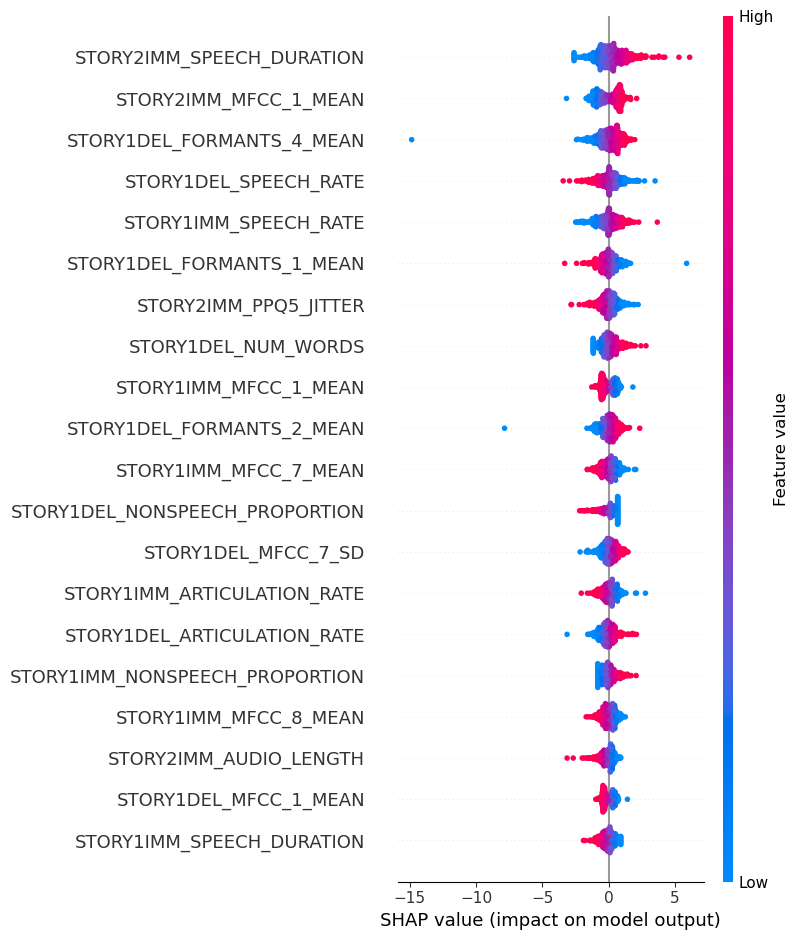


Top 20 predictors by mean |SHAP| – Logistic (m00->m12 ECOG change):
                     Predictor  MeanAbsSHAP
     STORY2IMM_SPEECH_DURATION     0.830355
         STORY2IMM_MFCC_1_MEAN     0.755027
     STORY1DEL_FORMANTS_4_MEAN     0.636984
         STORY1DEL_SPEECH_RATE     0.622633
         STORY1IMM_SPEECH_RATE     0.591766
     STORY1DEL_FORMANTS_1_MEAN     0.494790
         STORY2IMM_PPQ5_JITTER     0.467636
           STORY1DEL_NUM_WORDS     0.452003
         STORY1IMM_MFCC_1_MEAN     0.444864
     STORY1DEL_FORMANTS_2_MEAN     0.444422
         STORY1IMM_MFCC_7_MEAN     0.437976
STORY1DEL_NONSPEECH_PROPORTION     0.420441
           STORY1DEL_MFCC_7_SD     0.412452
   STORY1IMM_ARTICULATION_RATE     0.408121
   STORY1DEL_ARTICULATION_RATE     0.401834
STORY1IMM_NONSPEECH_PROPORTION     0.385476
         STORY1IMM_MFCC_8_MEAN     0.362799
        STORY2IMM_AUDIO_LENGTH     0.352665
         STORY1DEL_MFCC_1_MEAN     0.344579
     STORY1IMM_SPEECH_DURATION     0.336911


<Figure size 640x480 with 0 Axes>

In [61]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# ------------------------------------------------------------
# 1. Prepare full m00 -> m12 dataset (same as before)
# ------------------------------------------------------------
X_full_raw = df_00_12_model[feature_cols].values
y_full = df_00_12_model["ECOG_label_00_12"].values

print("[m00->m12] X_full_raw shape:", X_full_raw.shape, " y_full shape:", y_full.shape)

# ------------------------------------------------------------
# 2. Impute + scale explicitly (no Pipeline)
# ------------------------------------------------------------
imputer = SimpleImputer(strategy="median")
X_full_imp = imputer.fit_transform(X_full_raw)

scaler = StandardScaler()
X_full_scaled = scaler.fit_transform(X_full_imp)

# Logistic regression on scaled features
logit_glm = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="lbfgs",
    max_iter=2000,
    class_weight="balanced",
    random_state=42
)
logit_glm.fit(X_full_scaled, y_full)

# ------------------------------------------------------------
# 3. Choose background and explanation samples
# ------------------------------------------------------------
np.random.seed(42)

n_background = min(200, X_full_scaled.shape[0])
n_explain = min(500, X_full_scaled.shape[0])

background_idx = np.random.choice(X_full_scaled.shape[0], size=n_background, replace=False)
explain_idx = np.random.choice(X_full_scaled.shape[0], size=n_explain, replace=False)

X_background_scaled = X_full_scaled[background_idx, :]
X_explain_scaled = X_full_scaled[explain_idx, :]

# For plotting, keep the **raw** feature values (easier to interpret)
X_explain_raw = X_full_raw[explain_idx, :]
X_explain_df = pd.DataFrame(X_explain_raw, columns=feature_cols)

print("Background (scaled) shape:", X_background_scaled.shape)
print("Explain (scaled) shape:", X_explain_scaled.shape)

# ------------------------------------------------------------
# 4. SHAP LinearExplainer on logistic regression
# ------------------------------------------------------------
# For linear models, LinearExplainer is the most stable
explainer_lin = shap.LinearExplainer(
    logit_glm,
    X_background_scaled,
    feature_perturbation="interventional"
)

shap_vals = explainer_lin.shap_values(X_explain_scaled)
shap_vals = np.array(shap_vals)  # ensure ndarray

print("SHAP values shape:", shap_vals.shape)  # should be (n_explain, n_features)

# ------------------------------------------------------------
# 5. Beeswarm plot (top 20 features)
# ------------------------------------------------------------
plt.figure(figsize=(8, 6))
shap.summary_plot(
    shap_vals,
    X_explain_df,
    feature_names=feature_cols,
    max_display=20,
    show=True
)

# Save for poster / report
plt.savefig("shap_beeswarm_m00_12_logit_linear_explainer_top20.png",
            bbox_inches="tight", dpi=300)

# ------------------------------------------------------------
# 6. Tabular SHAP importance (mean |SHAP|)
# ------------------------------------------------------------
mean_abs_shap = np.abs(shap_vals).mean(axis=0)

shap_importance_logit = (
    pd.DataFrame({
        "Predictor": feature_cols,
        "MeanAbsSHAP": mean_abs_shap
    })
    .sort_values("MeanAbsSHAP", ascending=False)
)

print("\nTop 20 predictors by mean |SHAP| – Logistic (m00->m12 ECOG change):")
print(shap_importance_logit.head(20).to_string(index=False))

# Optional: CSV for your “Results” table in the science-fair packet
shap_importance_logit.head(20).to_csv(
    "shap_top20_m00_12_logit_linear_explainer.csv", index=False
)


[GLM] Using 1967 rows and 209 predictors after NA cleanup.
[GLM] m00->m12 ECOG change model fit complete.
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1967
Model:                            GLM   Df Residuals:                     1762
Model Family:                Binomial   Df Model:                          204
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1045.8
Date:                Thu, 05 Feb 2026   Deviance:                       2091.6
Time:                        13:43:47   Pearson chi2:                 1.93e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1311
Covariance

Top 20 GLM features (by p-value) for m00->m12 ECOG change:
                      Predictor      Coef         p
0         STORY1IMM_MFCC_8_MEAN -0.070343  0.004266
1       

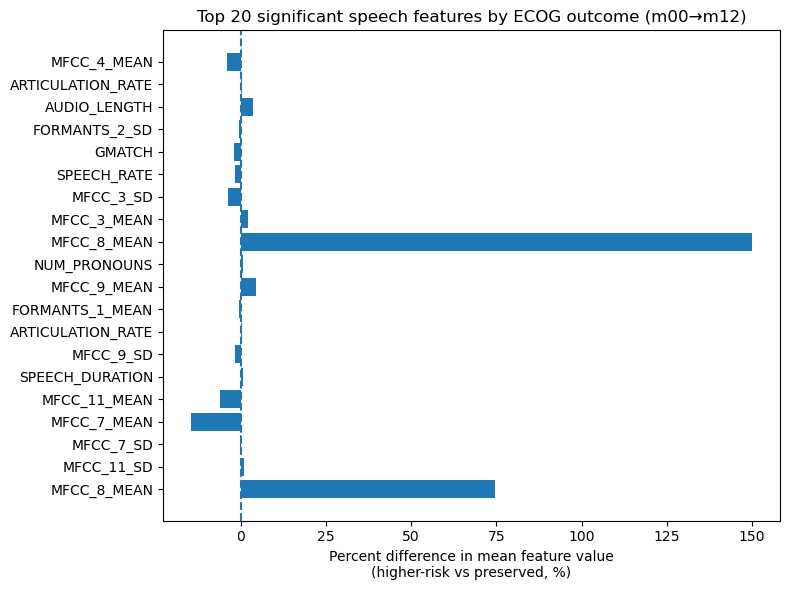


Edit `required_cols` to match the ECOG total column names in df_00_12_model.


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# ------------------------------------------------------------
# 0. Reconstruct feature set and CLEAN data for GLM (m00 -> m12)
#     Assumes df_00_12_model already exists in memory
# ------------------------------------------------------------

# Use all numeric predictors except ECOG outcome summaries
num_cols = df_00_12_model.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ["ECOG_label_00_12", "ECOG_total_00", "ECOG_total_06", "ECOG_total_12"]
feature_cols = [c for c in num_cols if c not in exclude_cols]

X_raw = df_00_12_model[feature_cols].copy()
y_raw = df_00_12_model["ECOG_label_00_12"].values

# Replace inf / -inf with NaN
X_glm = X_raw.replace([np.inf, -np.inf], np.nan)

# Drop columns that are all NaN just in case
all_nan_cols = X_glm.columns[X_glm.isna().all()]
if len(all_nan_cols) > 0:
    print("Dropping all-NaN columns from GLM:", list(all_nan_cols))
    X_glm = X_glm.drop(columns=all_nan_cols)

# Drop rows with ANY NaN in predictors
row_mask = ~X_glm.isna().any(axis=1)
X_glm_clean = X_glm.loc[row_mask].copy()
y_glm = y_raw[row_mask]

print(f"[GLM] Using {X_glm_clean.shape[0]} rows and {X_glm_clean.shape[1]} predictors after NA cleanup.")

# Add intercept and fit binomial GLM
X_glm_const = sm.add_constant(X_glm_clean)
glm_binom = sm.GLM(y_glm, X_glm_const, family=sm.families.Binomial())
glm_results = glm_binom.fit()

print("[GLM] m00->m12 ECOG change model fit complete.")
print(glm_results.summary().as_text()[:800])  # truncated

# ------------------------------------------------------------
# 1. Top 20 GLM predictors (by p-value)
# ------------------------------------------------------------
coef_table = pd.DataFrame({
    "Predictor": glm_results.params.index,
    "Coef": glm_results.params.values,
    "p": glm_results.pvalues.values
})

# Drop intercept
coef_table = coef_table[coef_table["Predictor"] != "const"]

top20_glm = coef_table.sort_values("p").head(20).reset_index(drop=True)
top_feats = top20_glm["Predictor"].tolist()

print("\nTop 20 GLM features (by p-value) for m00->m12 ECOG change:")
print(top20_glm[["Predictor", "Coef", "p"]])

# ------------------------------------------------------------
# 2. Percent-difference bar plot (higher-risk vs preserved)
# ------------------------------------------------------------

df_pres = df_00_12_model[df_00_12_model["ECOG_label_00_12"] == 0]
df_risk = df_00_12_model[df_00_12_model["ECOG_label_00_12"] == 1]

pct_diffs = []
labels_short = []

def shorten_name(name: str) -> str:
    for pref in ["STORY1DEL_", "STORY1IMM_", "STORY2IMM_"]:
        if name.startswith(pref):
            return name[len(pref):]
    return name

for f in top_feats:
    # Use original df_00_12_model for means (no row dropping)
    m0 = df_pres[f].mean(skipna=True)
    m1 = df_risk[f].mean(skipna=True)

    denom = np.abs(m0) if np.abs(m0) > 1e-6 else 1e-6
    pct = 100.0 * (m1 - m0) / denom
    pct_diffs.append(pct)
    labels_short.append(shorten_name(f))

pct_diffs = np.array(pct_diffs)
clip_val = 150  # cap extreme values for readability
pct_diffs_clipped = np.clip(pct_diffs, -clip_val, clip_val)

y_pos = np.arange(len(labels_short))

plt.figure(figsize=(8, 6))
plt.barh(y_pos, pct_diffs_clipped)
plt.yticks(y_pos, labels_short)
plt.axvline(0, linestyle="--")
plt.xlabel("Percent difference in mean feature value\n(higher-risk vs preserved, %)")
plt.title("Top 20 significant speech features by ECOG outcome (m00→m12)")
plt.tight_layout()
plt.savefig("barh_pctdiff_top20_m00_12.png", dpi=300, bbox_inches="tight")
plt.show()

# ------------------------------------------------------------
# 3. ECOG time-course plot: m00, m06, m12
# ------------------------------------------------------------
required_cols = ["ECOG_total_00", "ECOG_total_06", "ECOG_total_12"]
missing = [c for c in required_cols if c not in df_00_12_model.columns]

if missing:
    print("\nWARNING: Missing ECOG total columns:", missing)
    print("Edit `required_cols` to match the ECOG total column names in df_00_12_model.")
else:
    mean_00_pres = df_pres["ECOG_total_00"].mean(skipna=True)
    mean_06_pres = df_pres["ECOG_total_06"].mean(skipna=True)
    mean_12_pres = df_pres["ECOG_total_12"].mean(skipna=True)

    mean_00_risk = df_risk["ECOG_total_00"].mean(skipna=True)
    mean_06_risk = df_risk["ECOG_total_06"].mean(skipna=True)
    mean_12_risk = df_risk["ECOG_total_12"].mean(skipna=True)

    x = [0, 6, 12]
    labels = ["m00", "m06", "m12"]

    plt.figure(figsize=(6, 4))
    plt.plot(x, [mean_00_pres, mean_06_pres, mean_12_pres],
             marker="o", linestyle="-", label="Preserved function")
    plt.plot(x, [mean_00_risk, mean_06_risk, mean_12_risk],
             marker="o", linestyle="-", label="Higher-risk group")

    plt.xticks(x, labels)
    plt.xlabel("Visit month")
    plt.ylabel("Mean ECOG total score")
    plt.title("Change in everyday function over 12 months")
    plt.legend()
    plt.tight_layout()
    plt.savefig("ecog_timecourse_m00_m12.png", dpi=300, bbox_inches="tight")
    plt.show()


/var/folders/c4/25m939rn45d1_yzhcnr3wl400000gn/T/ipykernel_41348/2256396150.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Preserved", "Higher-risk"], rotation=0)
/var/folders/c4/25m939rn45d1_yzhcnr3wl400000gn/T/ipykernel_41348/2256396150.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Preserved", "Higher-risk"], rotation=0)
/var/folders/c4/25m939rn45d1_yzhcnr3wl400000gn/T/ipykernel_41348/2256396150.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Preserved", "Higher-risk"], rotation=0)
/var/folders/c4/25m939rn45d1_yzhcnr3wl400000gn/T/ipykernel_41348/2256396150.py:62: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_

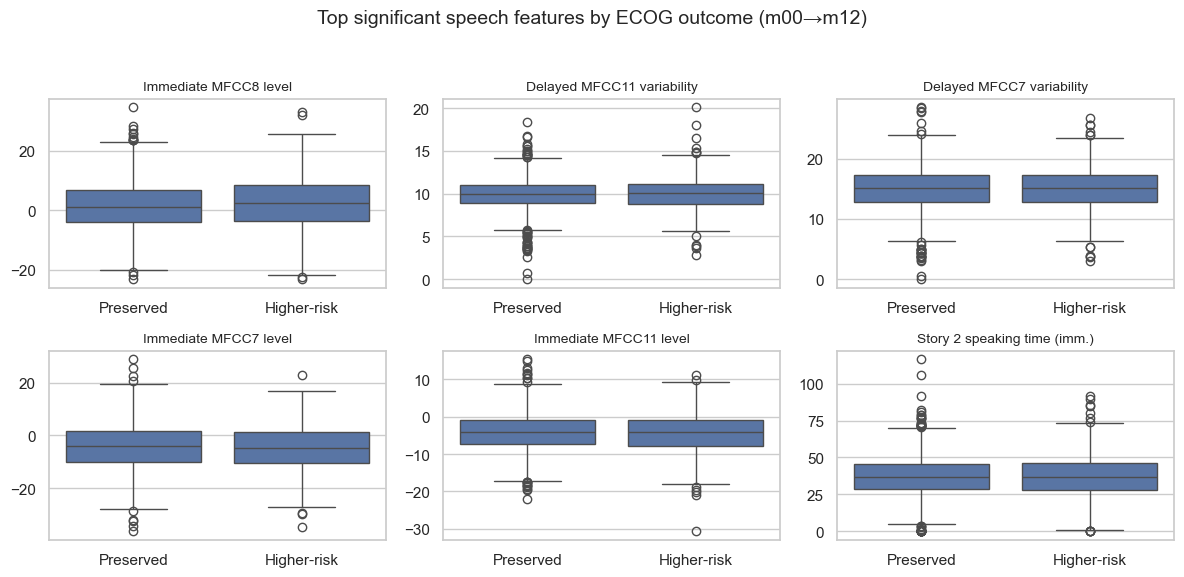

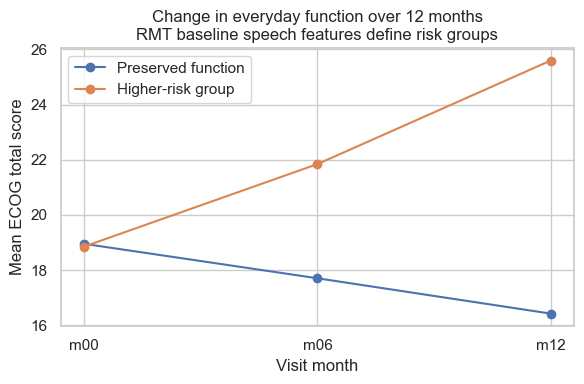

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# -------------------------------------------------------------------
# 1. Boxplots for top GLM features (raw values, not z-scores)
#    Assumes: top20_glm and df_00_12_model already exist
# -------------------------------------------------------------------

# Take the 6 most significant predictors
top6_feats = top20_glm["Predictor"].tolist()[:6]

def shorten_raw(name: str) -> str:
    """Strip story prefixes for plotting."""
    for pref in ["STORY1DEL_", "STORY1IMM_", "STORY2IMM_"]:
        if name.startswith(pref):
            return name[len(pref):]
    return name

pretty_labels = {
    "STORY1DEL_MFCC_7_SD":      "Delayed MFCC7 variability",
    "STORY1DEL_SPEECH_RATE":    "Delayed speech rate",
    "STORY2IMM_SPEECH_DURATION":"Story 2 speaking time (imm.)",
    "STORY1IMM_MFCC_7_MEAN":    "Immediate MFCC7 level",
    "STORY1DEL_MFCC_11_SD":     "Delayed MFCC11 variability",
    "STORY1IMM_ARTICULATION_RATE":"Immediate articulation rate",
    "STORY1IMM_MFCC_8_MEAN":    "Immediate MFCC8 level",
    "STORY1DEL_MFCC_3_SD":      "Delayed MFCC3 variability",
    "STORY1IMM_SPEECH_RATE":    "Immediate speech rate",
    "STORY1DEL_NONSPEECH_PROPORTION":"Delayed nonspeech proportion",
    "STORY2IMM_PPQ5_JITTER":    "Story 2 jitter (PPQ5, imm.)",
    "STORY1IMM_MFCC_11_MEAN":   "Immediate MFCC11 level",
    "STORY1IMM_MFCC_9_SD":      "Immediate MFCC9 variability",
    "STORY1DEL_FORMANTS_1_MEAN":"Delayed formant 1 (F1)",
    "STORY1IMM_APQ11_SHIMMER":  "Immediate shimmer (APQ11)",
    "STORY2IMM_NUM_PRONOUNS":   "Story 2 pronoun count (imm.)",
    "STORY1IMM_FORMANTS_2_SD":  "Immediate F2 variability",
    "STORY2IMM_GMATCH":         "Story 2 match score (GMATCH)",
    "STORY1IMM_MFCC_10_MEAN":   "Immediate MFCC10 level"
}

def nice_label(col):
    return pretty_labels.get(col, shorten_raw(col))

fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharey=False)
axes = axes.ravel()

for i, feat in enumerate(top6_feats):
    ax = axes[i]
    sns.boxplot(
        data=df_00_12_model,
        x="ECOG_label_00_12",
        y=feat,
        ax=ax
    )
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(nice_label(feat), fontsize=10)
    ax.set_xticklabels(["Preserved", "Higher-risk"], rotation=0)

# Hide any unused subplots (in case <6)
for j in range(len(top6_feats), len(axes)):
    axes[j].axis("off")

fig.suptitle("Top significant speech features by ECOG outcome (m00→m12)", fontsize=14)
fig.tight_layout(rect=[0, 0.02, 1, 0.95])
plt.savefig("boxplots_top6_features_m00_12_raw.png", dpi=300, bbox_inches="tight")
plt.show()

# -------------------------------------------------------------------
# 2. ECOG total time-course: m00, m06, m12 by risk group
#    Assumes: df_00_12_model with ECOG_label_00_12 and ADNIOnlineID
#             df_ecog and ecog_item_cols exist (or we recreate them)
# -------------------------------------------------------------------

# If df_ecog is not in memory, re-read it using your earlier path
try:
    df_ecog
except NameError:
    ecog_csv_path = "adnidata/RMT_ECOG12PT_01Feb2026.csv"
    ecog_item_cols = [f"RMT_ecogpt{i}" for i in range(1, 13)]
    df_ecog = pd.read_csv(ecog_csv_path)

# Compute ECOG total per record
df_ecog["ECOG_total"] = df_ecog[ecog_item_cols].sum(axis=1, skipna=True)

# Keep only m00, m06, m12 and pivot to wide per subject
ecog_wide = (
    df_ecog[df_ecog["RMT_Timepoint"].isin(["m00", "m06", "m12"])]
    .pivot_table(
        index="ADNIOnlineID",
        columns="RMT_Timepoint",
        values="ECOG_total",
        aggfunc="first"
    )
    .rename(columns={"m00": "ECOG_total_00", "m06": "ECOG_total_06", "m12": "ECOG_total_12"})
    .reset_index()
)

# Attach the 0/1 ECOG_label_00_12 per subject from df_00_12_model
labels = (
    df_00_12_model[["ADNIOnlineID", "ECOG_label_00_12"]]
    .drop_duplicates(subset="ADNIOnlineID")
)

ecog_wide = ecog_wide.merge(labels, on="ADNIOnlineID", how="inner")

# Group means by outcome
pres = ecog_wide[ecog_wide["ECOG_label_00_12"] == 0]
risk = ecog_wide[ecog_wide["ECOG_label_00_12"] == 1]

time_labels = ["m00", "m06", "m12"]
x_months = [0, 6, 12]

pres_means = [
    pres["ECOG_total_00"].mean(skipna=True),
    pres["ECOG_total_06"].mean(skipna=True),
    pres["ECOG_total_12"].mean(skipna=True)
]

risk_means = [
    risk["ECOG_total_00"].mean(skipna=True),
    risk["ECOG_total_06"].mean(skipna=True),
    risk["ECOG_total_12"].mean(skipna=True)
]

plt.figure(figsize=(6, 4))
plt.plot(x_months, pres_means, marker="o", linestyle="-", label="Preserved function")
plt.plot(x_months, risk_means, marker="o", linestyle="-", label="Higher-risk group")

plt.xticks(x_months, time_labels)
plt.xlabel("Visit month")
plt.ylabel("Mean ECOG total score")
plt.title("Change in everyday function over 12 months\nRMT baseline speech features define risk groups")
plt.legend()
plt.tight_layout()
plt.savefig("ecog_timecourse_m00_m12.png", dpi=300, bbox_inches="tight")
plt.show()


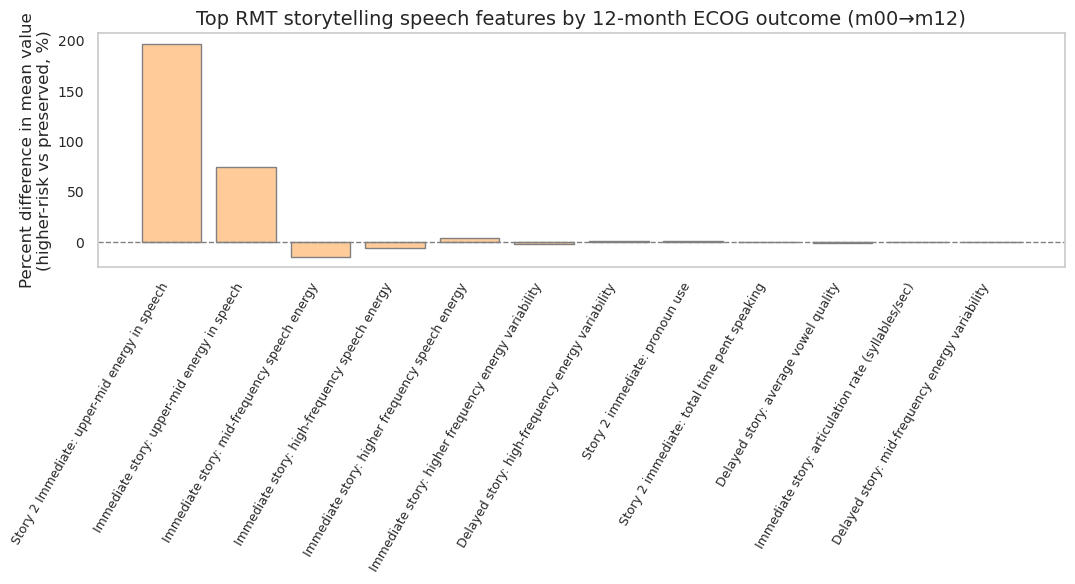

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# Assumes:
#   - df_00_12_model: modeling dataframe for m00→m12
#   - top20_glm: DataFrame with a "Predictor" column listing the 20 GLM features
# -------------------------------------------------------------------

# Nicer default fonts
plt.rcParams.update({
    "font.family": "DejaVu Sans",
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 9,
    "ytick.labelsize": 10
})

# ------------------------------------------------------------
# 1) Get the 20 features and group means (strip any whitespace)
# ------------------------------------------------------------
top20_feats = [f.strip() for f in top20_glm["Predictor"].tolist()]

top20_feats = top20_glm["Predictor"].tolist()[:12]

group_means = df_00_12_model.groupby("ECOG_label_00_12")[top20_feats].mean()
mean_pres = group_means.loc[0]   # preserved function
mean_risk = group_means.loc[1]   # higher-risk

# Percent difference: (risk - preserved) / |preserved|
eps = 1e-6
pct_diff = (mean_risk - mean_pres) / (np.abs(mean_pres) + eps) * 100.0

# ------------------------------------------------------------
# 2) Human-readable labels for exactly these 20 features
#    (all keys are the raw column names from your df_pct printout)
# ------------------------------------------------------------
nice_labels = {
    "STORY2IMM_MFCC_8_MEAN":      "Story 2 Immediate: upper-mid energy in speech",
    "STORY1IMM_MFCC_8_MEAN":      "Immediate story: upper-mid energy in speech",
    "STORY1IMM_MFCC_9_MEAN":      "Immediate story: higher frequency speech energy",
    "STORY2IMM_AUDIO_LENGTH":     "Story 2 Immediate: total story audio length",
    "STORY1DEL_MFCC_3_MEAN":      "Delayed story: low-frequency speech energy",
    "STORY1DEL_MFCC_11_SD":       "Delayed story: high-frequency energy variability",
    "STORY2IMM_NUM_PRONOUNS":     "Story 2 immediate: pronoun use",
    "STORY2IMM_SPEECH_DURATION":  "Story 2 immediate: total time pent speaking",
    "STORY1IMM_ARTICULATION_RATE":"Immediate story: articulation rate (syllables/sec)",
    "STORY1DEL_ARTICULATION_RATE":"Delayed story: articulation rate (syllables/sec)",
    "STORY1DEL_MFCC_7_SD":        "Delayed story: mid-frequency energy variability",
    "STORY1IMM_FORMANTS_2_SD":    "Immediate story: variability in vowel quality",
    "STORY1DEL_FORMANTS_1_MEAN":  "Delayed story: average vowel quality",
    "STORY1IMM_MFCC_9_SD":        "Immediate story: higher frequency energy variability",
    "STORY1IMM_SPEECH_RATE":      "Immediate story: words per second (speech rate)",
    "STORY2IMM_GMATCH":           "Story 2 immediate: narrative fidelity",
    "STORY1DEL_MFCC_3_SD":        "Delayed story: low-frequency energy variability",
    "STORY2IMM_MFCC_4_MEAN":      "Story 2 immediate: lower-mid speech energy",
    "STORY1IMM_MFCC_11_MEAN":     "Immediate story: high-frequency speech energy",
    "STORY1IMM_MFCC_7_MEAN":      "Immediate story: mid-frequency speech energy",
}



# Build DataFrame with percent differences and labels
df_pct = pd.DataFrame({
    "Feature": top20_feats,
    "PercentDiff": pct_diff.values
})

# Direct mapping: all 20 keys are present above
df_pct["NiceLabel"] = df_pct["Feature"].map(nice_labels)

# Sanity check (optional): make sure no raw names slipped through
if df_pct["NiceLabel"].isna().any():
    missing = df_pct.loc[df_pct["NiceLabel"].isna(), "Feature"].unique()
    print("WARNING – missing labels for:", missing)

# Sort so the *largest absolute* differences appear together
df_pct = df_pct.reindex(
    df_pct["PercentDiff"].abs().sort_values(ascending=False).index
).reset_index(drop=True)


# ------------------------------------------------------------
# 3) Vertical bar plot (no grid lines, soft color, nice labels)
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(11, 6))

bar_color = "#ffcc99"  # soft peach

x = np.arange(len(df_pct))
ax.bar(x, df_pct["PercentDiff"], color=bar_color, edgecolor="gray")

ax.axhline(0, color="gray", linestyle="--", linewidth=1)

ax.set_xticks(x)
ax.set_xticklabels(df_pct["NiceLabel"], rotation=60, ha="right")

ax.set_ylabel("Percent difference in mean value\n(higher-risk vs preserved, %)")
ax.set_xlabel("")
ax.set_title("Top RMT storytelling speech features by 12-month ECOG outcome (m00→m12)")

ax.grid(False)  # no background grid

plt.tight_layout()
plt.savefig("top20_percent_diff_vertical_m00_12.png",
            dpi=300, bbox_inches="tight")
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'set_ylim'

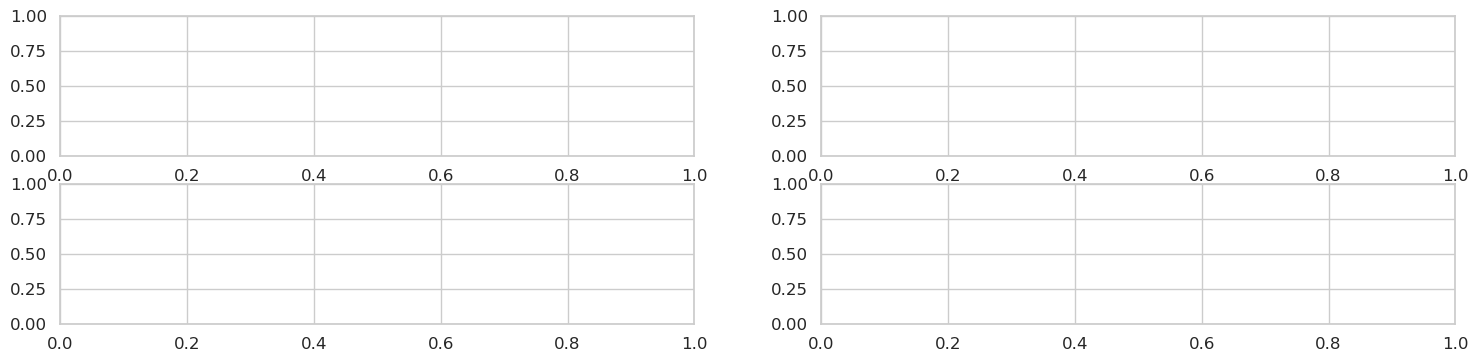

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import textwrap

# -------------------------------------------------------------------
# Assumes:
#   - df_00_12_model: modeling dataframe for m00->m12
#   - df_pct: columns ["Feature", "PercentDiff", "NiceLabel"]
#       (top20 from GLM, we’ll just take top 5)
# -------------------------------------------------------------------

top5 = df_pct.head(5).reset_index(drop=True)

plt.rcParams.update({
    "font.family": "DejaVu Sans",
    "axes.titlesize": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

color_preserved = "#99c2ff"   # soft blue
color_risk      = "#ffcc99"   # soft peach

def feature_unit(feat_name: str) -> str:
    """Return a simple unit label for the feature (for the range line)."""
    fname = feat_name.upper()
    if "AUDIO_LENGTH" in fname or "SPEECH_DURATION" in fname:
        return "seconds"
    if "SPEECH_RATE" in fname or "ARTICULATION_RATE" in fname:
        return "words per second"
    if "NUM_" in fname:
        return "count"
    if "GMATCH" in fname:
        return "similarity score"
    if any(tok in fname for tok in
           ["JITTER", "SHIMMER", "MFCC", "FORMANTS",
            "AMPLITUDE", "INTENSITY"]):
        return "acoustic units"
    return "arbitrary units"

fig, axes = plt.subplots(
    nrows=1, ncols=5,
    figsize=(18, 4),
    sharey=False
)

if not isinstance(axes, np.ndarray):
    axes = np.array([axes])

for i, (_, row) in enumerate(top5.iterrows()):
    feat       = row["Feature"]
    nice_label = row["NiceLabel"]
    ax         = axes[i]

    # All values for full-range text
    vals = df_00_12_model[feat].dropna()
    feat_min = float(vals.min())
    feat_max = float(vals.max())
    unit = feature_unit(feat)

    # Group means (what we actually plot)
    means = df_00_12_model.groupby("ECOG_label_00_12")[feat].mean()
    mean_pres = float(means.loc[0])   # preserved function
    mean_risk = float(means.loc[1])   # higher-risk
    bar_vals = [mean_pres, mean_risk]

    # Y-axis range: just around the two means
    mean_min = min(bar_vals)
    mean_max = max(bar_vals)
    mean_rng = mean_max - mean_min if mean_max != mean_min else 1.0
    y_min = mean_min - 0.3 * mean_rng
    y_max = mean_max + 0.3 * mean_rng
    ax.set_ylim(y_min, y_max)

    x = np.arange(2)
    bars = ax.bar(
        x,
        bar_vals,
        color=[color_preserved, color_risk],
        edgecolor="gray"
    )
    ax.set_xticks(x)
    ax.set_xticklabels(["Preserved", "Higher-risk"])

    # Nicely wrapped title and range line (TEXT ONLY, not used for scale)
    wrapped_label = "\n".join(textwrap.wrap(nice_label, width=26))
    range_line = f"Value range in data: {feat_min:.2f} to {feat_max:.2f} {unit}"
    wrapped_range = "\n".join(textwrap.wrap(range_line, width=30))
    ax.set_title(wrapped_label + "\n" + wrapped_range, pad=14)

    # Numeric mean labels inside each bar
    for j, b in enumerate(bars):
        val = bar_vals[j]
        # place slightly inside the bar
        if val >= 0:
            y_text = val - 0.05 * mean_rng
            va = "top"
        else:
            y_text = val + 0.05 * mean_rng
            va = "bottom"
        ax.text(
            b.get_x() + b.get_width() / 2.0,
            y_text,
            f"{val:.2f}",
            ha="center",
            va=va,
            fontsize=10,
            color="black"
        )

    if i == 0:
        ax.set_ylabel("Mean feature value")
    else:
        ax.set_ylabel("")

    ax.grid(False)

plt.tight_layout()
plt.savefig("top5_feature_means_zoomed_m00_12.png",
            dpi=300, bbox_inches="tight")
plt.show()
